# Pred2Town with XAI

Paper: Black Box Model Explanations and the Human Interpretability Expectations - An Analysis in the Context of Homicide Prediction



Generate files?


In [1]:
do_download = True #when change to True, run all notebook!
run_grid_search = False

## Install dependences

In [2]:
#!pip install --upgrade --upgrade-strategy only-if-needed scikit-learn==0.22
#!pip install --upgrade -U scikit-learn==0.22
!pip install --upgrade -U scikit-learn==1.0.2
!pip install lofo-importance
!pip install git+https://github.com/oracle/Skater.git #online usa-se este
!pip install info_gain
!pip install shap
!pip install eli5
!pip install dalex
!pip install py-ciu
!pip install plotly
!pip install adjustText
!pip install scikit_posthocs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Cloning https://github.com/oracle/Skater.git to /tmp/pip-req-build-z8j_r3ur
  Running command git clone --filter=blob:none --quiet https://github.com/oracle/Skater.git /tmp/pip-req-build-z8j_r3ur
  Resolved https://github.com/oracle/Skater.git to commit 1ad4b4657a51ede7312fd9545e0db46316d481b3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for skater: filename=skater-1.1.2b1-py3-none-any.whl size=120019

In [3]:
!pip install scipy
!pip install venn
!pip install scikit_posthocs

import numpy as np
import pandas as pd
import io
import regex
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scikit_posthocs as sp
import numpy as np
#import openml
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import statistics
import os
import gc
import math
import matplotlib.cm as cm
import csv
import io

from scipy import stats
from copy import deepcopy
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from scipy.stats import friedmanchisquare
from scipy.stats import spearmanr
from sklearn.metrics import silhouette_samples, silhouette_score
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import cm
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn import preprocessing
from matplotlib.pyplot import subplots
from venn import venn
from matplotlib_venn import venn2, venn2_circles


  Preparing metadata (setup.py) ... done
  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19698 sha256=c2680c0d29582a6ce4a416dc5e6014f4f71170e3e94194f087a75f1b7aed052a
  Stored in directory: /root/.cache/pip/wheels/9c/ce/43/705b4a04cd822891d1d7a4c43fc444b4798978e72c79528c5f
Successfully built venn


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
#!pip install lofo-importance
#!pip install git+https://github.com/oracle/Skater.git
#!pip install shap
#!pip install eli5
#!pip install py-ciu

import eli5
import shap
import dalex as dx
from ciu import determine_ciu
from lofo import LOFOImportance, FLOFOImportance, Dataset
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [6]:
from google.colab import files

## Util

In [7]:
class Util():

  def intersection(v1, v2):
    v3 = [value for value in v1 if value in v2]
    return v3

  def repareSizeNew(v1, v2):
    sv1 = Util.intersection(v1,v2)
    sv2 = Util.intersection(v2,v1)
    return sv1, sv2


  def repareSize(v1, v2):
    len1 = len(v1)
    len2 = len(v2)
    vBig = []
    vSma = []
    if len1 > len2:
      vBig = v1
      vSma = v2
    if len1 < len2:
      vBig = v2
      vSma = v1

    i = 0
    vBigCopy = vBig.copy()
    while len(vBig) > len(vSma):
      element = vBigCopy[i]
      if not element in vSma: # elemento do vetor maior nao existe no vetor menor
        vBig.remove(element)
      i+=1

    if len1 > len2:
      return vBig, vSma
    if len1 < len2:
      return vSma, vBig

    return v1, v2



  def is_int(n):
    isInteger = False
    for i in range(len(n)):
      if isinstance(n[i],float):
        return False
    return True

## XAI tools

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  4 14:32:39 2021

@author: Jose Ribeiro
"""

class ExplainableTools():
  def explainRankByLofo(model,X,Y,names_x_attributes):
    df = X.copy()
    df['class'] = Y.to_list()
    dataset = Dataset(df=df, target="class", features=names_x_attributes)
    fi = LOFOImportance(dataset, scoring='roc_auc', model=model)
    importances = fi.get_importance()
    importances = importances.sort_values(by=['importance_mean','feature'],ascending=False) #fix problem of equals values of explaination
    return importances['feature'].to_list()

  def explainRankByEli5(model, names_x_attributes):
      rank = eli5.explain_weights_df(model,  feature_names = names_x_attributes)
      rank = rank.sort_values(by=['weight','feature'],ascending=False) #fix problem of equals values of explaination
      return rank['feature'].to_list()


  def explainRankByKernelShap(model,x_features_names, X,is_gradient=False): # shap.sample(data, K) or shap.kmeans(data, K)
    np.random.seed(0)
    explainer = shap.KernelExplainer(model.predict_proba, X[:],nsamples=len(x_features_names))
    shap_values = explainer.shap_values(X[:])
    if is_gradient == False:
        vals= np.abs(shap_values).sum(1)
    else:
        vals= np.abs([shap_values]).sum(1) #correction []
    temp_df = pd.DataFrame(list(zip(x_features_names, sum(vals))), columns=['feat_name','shap_value'])
    temp_df = temp_df.sort_values(by=['shap_value','feat_name'], ascending=False) #fix problem of equals values of explaination
    return list(temp_df['feat_name'])


  def explainRankByTreeShap(model, x_features_names, X, is_gradient=False):
      np.random.seed(0)
      shap_values = shap.TreeExplainer(model).shap_values(X)
      if is_gradient == False:
        vals= np.abs(shap_values).mean(0)
      else:
        vals= np.abs([shap_values]).mean(0) #correction []
      temp_df = pd.DataFrame(list(zip(x_features_names, sum(vals))), columns=['feat_name','shap_value'])
      temp_df = temp_df.sort_values(by=['shap_value','feat_name'], ascending=False) #fix problem of equals values of explaination

      return temp_df['feat_name'].to_list()

  def explainRankByCiu(model, x_test, feature_names,context_dic,rank):

    def _makeRankByCu(ciu):
      df_cu = pd.DataFrame(list(ciu.cu.items()), columns=['attribute', 'cu'])
      df_cu = df_cu.sort_values(by='cu', ascending=False)
      #ciu.plot_cu()
      return df_cu['attribute'].to_list()

    def _makeRankByCi(ciu):
      df_ci = pd.DataFrame(list(ciu.ci.items()), columns=['attribute', 'ci'])
      df_ci = df_ci.sort_values(by=['ci','attribute'], ascending=False) #fix problem of equals values of explaination
      return df_ci['attribute'].to_list()

    case = x_test.values[0]
    example_prediction = model.predict([x_test.values[0]])
    example_prediction_probs = model.predict_proba([x_test.values[0]])
    prediction_index = list(example_prediction_probs[0]).index(max(example_prediction_probs[0]))




    ciu = determine_ciu(
        x_test.iloc[[1]],
        model.predict_proba,
        X.to_dict('list'),
        samples = 1000,
        prediction_index = 1)

    if rank == 'ci':
      result = _makeRankByCi(ciu)
    else:
      if rank == 'cu':
        result = _makeRankByCu(ciu)
      else:
        result = {}

    #ciu
    return result

  def explainRankByAlibi(model_path,X_train): # -- deprecated
    model = tf.keras.models.load_model(model_path)
    ig  = IntegratedGradients(model, layer=None, method="gausslegendre",
                          n_steps=50, internal_batch_size=100)
    explanation = ig.explain(X_train, baselines=None, target=None)
    attributions = explanation.attributions
    return attributions

  def explainRankSkater(model, X, x_features_names):
    interpreter = Interpretation(X.to_numpy(), feature_names=x_features_names)
    model_new = InMemoryModel(model.predict_proba,examples=X.to_numpy(),probability=True)
    rank = interpreter.feature_importance.feature_importance(model_new,ascending=False, progressbar=False)
    rank = rank.to_frame(name='values')
    rank = rank.reset_index()
    rank = rank.rename(columns={'index':'variable','values':'values'})
    rank = rank.sort_values(by=['values','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].to_list()

  def explainRankDalex(model, X_train, y_train):
    explainer = dx.Explainer(model, X_train, y_train,verbose=False)
    explanation = explainer.model_parts()
    rank = explanation.result
    rank = rank[rank.variable != '_baseline_']
    rank = rank[rank.variable != '_full_model_']
    rank = rank.sort_values(by=['dropout_loss','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].tolist()

  #Calculando ganho de informacao


  def explainRankByInfoGain(X,Y, attribute_X_names):



    def InfoGain(data,attribute_X_name,target_name):
      """
      Calculate the information gain of a dataset. This function takes three parameters:
      1. data = The dataset for whose feature the IG should be calculated
      2. attribute_X_name = the name of the feature for which the information gain should be calculated
      3. target_name = the name of the target feature. The default for this example is "class"
      """

      def entropy(target_col):
        """
        Calculate the entropy of a dataset.
        The only parameter of this function is the target_col parameter which specifies the target column
        """
        elements,counts = np.unique(target_col,return_counts = True)
        entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
        return entropy



      #Calculate the entropy of the total dataset
      total_entropy = entropy(data[target_name])

      ##Calculate the entropy of the dataset

      #Calculate the values and the corresponding counts for the split attribute
      vals,counts= np.unique(data[attribute_X_name],return_counts=True)

      #Calculate the weighted entropy
      Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[attribute_X_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])

      #Calculate the information gain
      result = total_entropy - Weighted_Entropy

      return result

    data = X.copy()
    target_name = 'class'
    data[target_name] = Y.to_list()

    rank = pd.Series([InfoGain(data,feature,target_name) for feature in attribute_X_names], index=attribute_X_names).sort_values(ascending=False)
    rank = rank.to_frame(name='values')
    rank = rank.reset_index()
    rank = rank.rename(columns={'index':'variable','values':'values'})
    rank = rank.sort_values(by=['values','variable'],ascending=False) #fix problem of equals values of explaination
    return rank['variable'].to_list()



## Preprocess

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  3 14:55:08 2021

@author: Jose Ribeiro
"""
class PreprocessDefault():

  def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()

    return df_std

  def normalize(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        if(len(df_norm[column].unique()) > 1): #fix NaN generation
          df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        else:
          df_norm[column] = 0
    return df_norm






## Analysis

In [105]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  3 16:02:02 2021

@author: Jose Ribeiro
"""

class AnalysisDefault():

  do_download_files = do_download

  def calcAccuracyPrecisionRecallByModel(y_test,y_pred):
      ac = [accuracy_score(y_test, y_pred)]
      pr = [precision_score(y_test, y_pred)]
      re = [recall_score(y_test, y_pred)]

      d = {'Accuracy': ac,
              'Precision': pr,
              'Recall': re}
      dataframe_analisys = pd.DataFrame(data=d)
      print("")
      print(dataframe_analisys)
      print("")
      return ac, pr, re



  def calcCrossValidation(model, X_train, y_train, cv, plotGraph):
      hit_rates = cross_val_score(model, X_train, y_train, cv=cv)
      if plotGraph == True:
          sns.kdeplot(data=hit_rates,legend=True,bw_method=0.7)

      return hit_rates

  def plotComparationCrossValidation(hr_rf,hr_gb,hr_dt, file_name):
      dt_tmp = {
            'GB':hr_gb,
            'DT':hr_dt,
            'RF':hr_rf
            }
      dt_tmp = pd.DataFrame(dt_tmp)

      fig, ax = plt.subplots(figsize=(8,6))
      sns.kdeplot(data=dt_tmp,legend=True,bw_method=0.7)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name)
      plt.show()

  def plotFriedmanTest(hr_rf,hr_gb,hr_dt, file_name):
      a = [hr_rf.tolist(),hr_gb.tolist(), hr_dt.tolist()]

      print('Friedman Test')
      print(friedmanchisquare(*a))
      posthoc = sp.posthoc_nemenyi_friedman(list(map(list, zip(*a))))
      models_names = ['RF','GB', 'DT']
      ax = sns.heatmap(posthoc, vmin=0, vmax=1, xticklabels=models_names,yticklabels=models_names,cmap="Greens",linewidths=.5,annot=True)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name)
      plt.show()

  def plotFriedmanTestDataProperty(c0,c1,c2, file_name):
      a = [c0.tolist(),c1.tolist(), c2.tolist()]

      print('Friedman Test')
      print(friedmanchisquare(*a))
      posthoc = sp.posthoc_nemenyi_friedman(list(map(list, zip(*a))))
      models_names = ['c0','c1', 'c2']
      ax = sns.heatmap(posthoc, vmin=0, vmax=1, xticklabels=models_names,yticklabels=models_names,cmap="Greens",linewidths=.5,annot=True)
      plt.savefig(file_name)
      if do_download_files == True:
        files.download(file_name)
      plt.show()

  def calcJaccardScore(m, n):
    score = jaccard_score(m,n)
    return score

  def calcGoodmanKruskalGamma(m, n):
    """
    compute the Goodman and Kruskal gamma rank correlation coefficient;
    this statistic ignores ties is unsuitable when the number of ties in the
    data is high. it's also slow.

    >>> x = [2, 8, 5, 4, 2, 6, 1, 4, 5, 7, 4]
    >>> y = [3, 9, 4, 3, 1, 7, 2, 5, 6, 8, 3]
    >>> goodman_kruskal_gamma(x, y)
    0.9166666666666666
    """
    num = 0
    den = 0
    for (i, j) in permutations(range(len(m)), 2):
        m_dir = m[i] - m[j]
        n_dir = n[i] - n[j]
        sign = m_dir * n_dir
        if sign > 0:
            num += 1
            den += 1
        elif sign < 0:
            num -= 1
            den += 1
    return num / float(den)


  def calcKendallCoef(d1,d2):
    coef, p = stats.kendalltau(d1, d2)
    return coef, p

  def calcSpearmanCoef(d1,d2):
    coef, p = spearmanr(d1, d2)
    return coef, p

  def calcSpearmanCoefWithDel(d1,d2):
    d1_copy = d1.copy()
    d2_copy = d2.copy()
    count1 = 0
    count2 = 0

    for i in range(len(d1_copy)):
      flag = False
      for ii in range(len(d2_copy)):
        if d1_copy[i] == d2_copy[ii]:
          flag = True
      if flag == False:
        d1_copy[i] = 'X'
        count1 += 1

    for i in range(len(d2_copy)):
      flag = False
      for ii in range(len(d1_copy)):
        if d2_copy[i] == d1_copy[ii]:
          flag = True
      if flag == False:
        d2_copy[i] = 'X'
        count2 += 1

    print(d1_copy)
    print()
    print(d2_copy)

    for i in range(count1):
      d1_copy.remove('X')
    for i in range(count2):
      d2_copy.remove('X')


    print(d1_copy)
    print()
    print(d2_copy)
    coef, p = spearmanr(d1_copy, d2_copy)
    return coef

  def calcCountEqual(d1,d2):
    equals = 0
    for i in range(len(d1)):
      if d1[i] == d2[i]:
        equals = equals + 1
    return equals

  def calcCountCommon(d1,d2):
    #Conta variaveis em comum entre as listas
    common = 0
    for i in range(len(d1)):
      for ii in range(len(d2)):
        if d1[i] == d2[ii]:
          common = common + 1
    return common



  #InformationGain
  ###################



  ###################

  ###################


  def calcInfoGain(data,split_attribute_name,target_name="class"):
      """
      Calculate the information gain of a dataset. This function takes three parameters:
      1. data = The dataset for whose feature the IG should be calculated
      2. split_attribute_name = the name of the feature for which the information gain should be calculated
      3. target_name = the name of the target feature. The default for this example is "class"
      """
      def _entropy(target_col):
        """
        Calculate the entropy of a dataset.
        The only parameter of this function is the target_col parameter which specifies the target column
        """
        elements,counts = np.unique(target_col,return_counts = True)
        entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
        return entropy


      #Calculate the entropy of the total dataset
      total_entropy = _entropy(data[target_name])

      ##Calculate the entropy of the dataset

      #Calculate the values and the corresponding counts for the split attribute
      vals,counts= np.unique(data[split_attribute_name],return_counts=True)

      #Calculate the weighted entropy
      Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*_entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])

      #Calculate the information gain
      Information_Gain = total_entropy - Weighted_Entropy
      return Information_Gain



## Data loading and preparation

In [11]:
dataset_name = 'pred2town'
file_dataset_name = 'Pred2Town_Pre-processed_by_Orange_binary_class_with_metadata_clean.csv'
name_target_class = 'Class'
uploaded1 = files.upload()
df = pd.read_csv(io.BytesIO(uploaded1[file_dataset_name]),index_col=0, encoding="UTF-8", sep=",")

Saving Pred2Town_Pre-processed_by_Orange_binary_class_with_metadata_clean.csv to Pred2Town_Pre-processed_by_Orange_binary_class_with_metadata_clean.csv


In [12]:
np.random.seed(42)
# Set target value and others features.
y_feature_name = name_target_class

Y = (df[y_feature_name].astype(int))

x_features_names = list(df.head(0))
x_features_names.remove(name_target_class)
X =  df[x_features_names]
df_pred2town_origin = df.copy()

In [13]:
df

,mes_num_crb,quant_lesao_corporal_crb,quant_ameaca_crb,quant_roubo_crb,quant_injuria_crb,quant_furto_crb,quant_lesao_no_transito_crb,quant_dano_no_transito_crb,quant_difamacao_crb,quant_homicidio_crb,...,quant_receptacao_crb,quant_estupro_crb,quant_desaparecimento_de_pessoa_crb,quant_tentativa_de_homicidio_crb,quant_poluicao_sonora_crb,quant_outras_fraudes_crb,quant_desobediencia_crb,quant_desacato_crb,quant_perturbacoes_da_tranquilidade_crb,Class
0,1.0,0.000000,0.048193,0.002433,0.00000,0.020619,0.000000,0.000000,0.000000,0.071429,...,0.166667,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0
1,1.0,0.081633,0.084337,0.124088,0.03125,0.036082,0.233333,0.000000,0.000000,0.071429,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,1
2,1.0,0.000000,0.132530,0.063260,0.03125,0.018041,0.066667,0.027027,0.000000,0.000000,...,0.000000,0.0,0.2,0.0,0.000000,0.0,0.166667,0.0,0.125,1
3,1.0,0.183673,0.168675,0.141119,0.06250,0.126289,0.100000,0.027027,0.000000,0.000000,...,0.000000,0.0,0.4,0.0,0.000000,0.0,0.166667,0.4,0.125,0
4,1.0,0.040816,0.012048,0.017032,0.00000,0.038660,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.2,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648,12.0,0.306122,0.289157,0.141119,0.15625,0.118557,0.100000,0.060811,0.166667,0.071429,...,0.000000,0.0,0.2,0.2,0.000000,0.0,0.000000,0.0,0.000,0
2649,12.0,0.183673,0.277108,0.192214,0.28125,0.381443,0.366667,0.506757,0.222222,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.000,0
2650,12.0,0.040816,0.012048,0.043796,0.00000,0.015464,0.000000,0.047297,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0
2652,12.0,0.040816,0.060241,0.075426,0.06250,0.090206,0.066667,0.243243,0.166667,0.071429,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y,random_state=21) # 70% training and 30% tes

## Calculate ranks

In [138]:
do_download_files = do_download

apply_smote = False


#This dataset will be complete (with values) only in final of notebook
dt = {'dataset_name':[],
        'model_name':[],
        'model_params':[],
        'accuracy':[],
        'precision':[],
        'recall':[],
        'correct_true':[],
        'correct_false':[]}
df_models_info = pd.DataFrame(dt)

dt = {'dataset_name':[],
        'model_name':[],
        'xai_vs_xai':[],
        'correlation':[]}
df_resume_boxplot = pd.DataFrame(dt)



#if run_train_test_model_* is False the upload of model is required
run_train_test_model_rf = True

crossvalidation = 7

cv_grid_search = crossvalidation

save_split_train_test_data = True


df_models_info.loc[0,'dataset_name'] = str(dataset_name)



dt = {'att_original_names':[],
      'tshap_rf':[],
      'eli5_rf':[],
      'dalex_rf':[],
      'ci_rf':[],
      'skater_rf':[],
      'lofo_rf':[],
      'human_1':[],
      'human_2':[],
      'human_3':[],}

df_feature_rank = pd.DataFrame(dt)
attribute_names = X.columns.to_list()
df_feature_rank['att_original_names'] = attribute_names


#normalize data by min-max
X = PreprocessDefault.normalize(X)

#print("pos processado")
print(X.head(n=100))

#create context dictionary (necessary to CIU)
context_dic = {}
for k in range(len(attribute_names)):
  context_dic[attribute_names[k]] = [min(X[attribute_names[k]]), max(X[attribute_names[k]]), Util.is_int(X[attribute_names[k]])]


#split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y) # 70% training and 30% test

if save_split_train_test_data == True:
    name_dataset = dataset_name

    if do_download_files == True:
      X_train.to_csv("X_train_"+name_dataset+".csv")
      files.download("X_train_"+name_dataset+".csv")

      X_test.to_csv("X_test_"+name_dataset+".csv")
      files.download("X_test_"+name_dataset+".csv")

      y_train.to_csv("y_train_"+name_dataset+".csv")
      files.download("y_train_"+name_dataset+".csv")

      y_test.to_csv("y_test_"+name_dataset+".csv")
      files.download("y_test_"+name_dataset+".csv")


#execution of model RF

file_name = 'model_rf_'+dataset_name+'.sav'

df_models_info.loc[1,'model_name'] = 'RF'

if run_train_test_model_rf == True:

  if run_grid_search == True:
    param_grid = {
        'max_depth': [1, 6, 12],
        'bootstrap': [True, False],
        'n_estimators': [10, 100, 200],
        'min_samples_leaf': [1, 10, 20, 40],
        'ccp_alpha': [0.0, 0.4],
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2']
    }


    # Create a based model
    model_rf = RandomForestClassifier()
    # Instantiate the grid search model
    #https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
    grid_search = GridSearchCV(estimator = model_rf, param_grid = param_grid,
                              cv = StratifiedKFold(cv_grid_search), n_jobs = 3, verbose = 2,scoring = 'roc_auc')


    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    grid_search.best_params_

    model_rf = grid_search.best_estimator_
  else:
    #params selected by gridsearch
    model_rf = RandomForestClassifier(bootstrap=True, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
    model_rf.fit(X_train, y_train)


  #save model
  pickle.dump(model_rf, open(file_name, 'wb'))
  if do_download_files == True:
    files.download(file_name)
else:
  model_rf = pickle.load(open(file_name, 'rb'))

y_pred_rf=model_rf.predict(X_test)

df_models_info.loc[1,'model_params'] = str(model_rf.get_params())

#analysis precision, accuracy and recall
ac, pr, re = AnalysisDefault.calcAccuracyPrecisionRecallByModel(y_test,y_pred_rf)

df_models_info.loc[1,'accuracy'] = ac
df_models_info.loc[1,'precision'] = pr
df_models_info.loc[1,'recall'] = re

#deepcopys
model_rf_shap = deepcopy(model_rf)
model_rf_eli5 = deepcopy(model_rf)
model_rf_dalex = deepcopy(model_rf)
model_rf_ciu = deepcopy(model_rf)
model_rf_skater = deepcopy(model_rf)
model_rf_lofo = deepcopy(model_rf)

#statistical analysis
hit_rates = AnalysisDefault.calcCrossValidation(model_rf,X_train, y_train, crossvalidation, False)
hit_rates_rf = hit_rates


#explanation by tree shap
df_feature_rank['tshap_rf'] = ExplainableTools.explainRankByTreeShap(model_rf_shap, attribute_names, X_test)


#explanation by eli5
df_feature_rank['eli5_rf'] = ExplainableTools.explainRankByEli5(model_rf_eli5,attribute_names)


#explanation by dalex
df_feature_rank['dalex_rf'] = ExplainableTools.explainRankDalex(model_rf_dalex,X_test, y_test)

#explanation by ci
df_feature_rank['ci_rf'] = ExplainableTools.explainRankByCiu(model_rf_ciu, X_test, attribute_names, context_dic,rank='ci')

#explanation by skater
df_feature_rank['skater_rf'] = ExplainableTools.explainRankSkater(model_rf_skater, X_test, attribute_names)

#explanation by lofo
df_feature_rank['lofo_rf'] = ExplainableTools.explainRankByLofo(model_rf_lofo, X_test, y_test, attribute_names)

#explanation by human_1
df_feature_rank['human_1'] = ["mes_num_crb","quant_homicidio_crb","quant_tentativa_de_homicidio_crb",
                              "quant_roubo_crb","quant_roubo_de_veiculo_crb","quant_desaparecimento_de_pessoa_crb",
                              "quant_ameaca_crb","quant_conflitos_vicinais_crb","quant_estupro_crb",
                              "quant_agressao_fisica_crb","quant_abandono_do_lar_crb",
                              "quant_apropriacao_indebita_crb","quant_calunia_crb",
                              "quant_conflitos_conjugais_crb","quant_conflitos_familiares_crb",
                              "quant_dano_civil_crb","quant_dano_crb","quant_dano_no_transito_crb",
                              "quant_desacato_crb","quant_desobediencia_crb","quant_difamacao_crb",
                              "quant_estelionato_crb","quant_estupro_de_vulneravel_crb","quant_fuga_do_lar_crb",
                              "quant_furto_crb","quant_injuria_crb","quant_lesao_corporal_crb","quant_lesao_no_transito_crb",
                              "quant_outras_fraudes_crb","quant_outros_fatos_atipicos_crb","quant_perturbacoes_da_tranquilidade_crb",
                              "quant_poluicao_sonora_crb","quant_receptacao_crb","quant_trafico_de_drogas_crb","quant_vias_de_fato_crb"]

#explanation by human_2
df_feature_rank['human_2'] = ["quant_homicidio_crb","quant_tentativa_de_homicidio_crb","quant_roubo_crb","quant_roubo_de_veiculo_crb",
                              "quant_estupro_crb","quant_estupro_de_vulneravel_crb","quant_trafico_de_drogas_crb","quant_lesao_corporal_crb",
                              "quant_agressao_fisica_crb","quant_ameaca_crb","quant_abandono_do_lar_crb","quant_apropriacao_indebita_crb",
                              "quant_calunia_crb","quant_conflitos_conjugais_crb","quant_conflitos_familiares_crb","quant_conflitos_vicinais_crb",
                              "quant_dano_civil_crb","quant_dano_crb","quant_dano_no_transito_crb","quant_desobediencia_crb",
                              "quant_difamacao_crb","quant_estelionato_crb","quant_fuga_do_lar_crb","quant_desaparecimento_de_pessoa_crb",
                              "quant_furto_crb","quant_injuria_crb","quant_lesao_no_transito_crb",
                              "quant_desacato_crb","mes_num_crb","quant_outras_fraudes_crb","quant_outros_fatos_atipicos_crb",
                              "quant_perturbacoes_da_tranquilidade_crb","quant_poluicao_sonora_crb",
                              "quant_receptacao_crb","quant_vias_de_fato_crb"]


#explanation by human_3
df_feature_rank['human_3'] = ["quant_conflitos_conjugais_crb","quant_conflitos_familiares_crb","quant_lesao_corporal_crb",
                              "quant_estupro_crb","quant_estupro_de_vulneravel_crb","quant_tentativa_de_homicidio_crb",
                              "quant_homicidio_crb","quant_roubo_crb","quant_roubo_de_veiculo_crb","quant_trafico_de_drogas_crb",
                              "quant_abandono_do_lar_crb","quant_agressao_fisica_crb","quant_ameaca_crb","quant_apropriacao_indebita_crb",
                              "quant_calunia_crb","quant_conflitos_vicinais_crb","quant_dano_civil_crb","quant_dano_crb",
                              "quant_dano_no_transito_crb","quant_desacato_crb","quant_desaparecimento_de_pessoa_crb",
                              "quant_desobediencia_crb","quant_difamacao_crb","quant_estelionato_crb","quant_fuga_do_lar_crb",
                              "quant_furto_crb","quant_injuria_crb","quant_lesao_no_transito_crb","mes_num_crb","quant_outras_fraudes_crb",
                              "quant_outros_fatos_atipicos_crb","quant_perturbacoes_da_tranquilidade_crb","quant_poluicao_sonora_crb",
                              "quant_receptacao_crb","quant_vias_de_fato_crb"]

#explanation by human_4
df_feature_rank['human_4'] = ["quant_ameaca_crb","quant_vias_de_fato_crb","quant_agressao_fisica_crb","quant_lesao_corporal_crb",
                              "quant_conflitos_familiares_crb","quant_conflitos_vicinais_crb","quant_conflitos_conjugais_crb",
                              "quant_trafico_de_drogas_crb","quant_tentativa_de_homicidio_crb","quant_homicidio_crb",
                              "quant_abandono_do_lar_crb","quant_apropriacao_indebita_crb","quant_calunia_crb","quant_dano_civil_crb",
                              "quant_dano_crb","quant_dano_no_transito_crb","quant_desacato_crb","quant_desaparecimento_de_pessoa_crb",
                              "quant_desobediencia_crb","quant_difamacao_crb","quant_estelionato_crb","quant_estupro_crb",
                              "quant_estupro_de_vulneravel_crb","quant_furto_crb","quant_fuga_do_lar_crb","quant_injuria_crb",
                              "quant_lesao_no_transito_crb","mes_num_crb","quant_outras_fraudes_crb","quant_outros_fatos_atipicos_crb",
                              "quant_perturbacoes_da_tranquilidade_crb","quant_poluicao_sonora_crb","quant_receptacao_crb","quant_roubo_crb",
                              "quant_roubo_de_veiculo_crb"]

#explanation by human_5
df_feature_rank['human_5'] = ["quant_homicidio_crb","quant_tentativa_de_homicidio_crb","quant_trafico_de_drogas_crb","quant_roubo_crb",
                              "quant_conflitos_vicinais_crb","quant_lesao_corporal_crb","quant_ameaca_crb","quant_estupro_crb",
                              "quant_estupro_de_vulneravel_crb","quant_desaparecimento_de_pessoa_crb","quant_perturbacoes_da_tranquilidade_crb",
                              "quant_agressao_fisica_crb","mes_num_crb","quant_outros_fatos_atipicos_crb","quant_furto_crb",
                              "quant_roubo_de_veiculo_crb","quant_vias_de_fato_crb","quant_dano_no_transito_crb","quant_calunia_crb",
                              "quant_injuria_crb","quant_difamacao_crb","quant_poluicao_sonora_crb","quant_estelionato_crb",
                              "quant_receptacao_crb","quant_lesao_no_transito_crb","quant_conflitos_conjugais_crb","quant_apropriacao_indebita_crb",
                              "quant_outras_fraudes_crb","quant_conflitos_familiares_crb","quant_dano_crb","quant_dano_civil_crb",
                              "quant_desacato_crb","quant_desobediencia_crb","quant_fuga_do_lar_crb","quant_abandono_do_lar_crb"]

#explanation by human_6
df_feature_rank['human_6'] = ["quant_estupro_crb","quant_trafico_de_drogas_crb","quant_roubo_crb","quant_desaparecimento_de_pessoa_crb",
                              "quant_ameaca_crb","quant_agressao_fisica_crb","quant_vias_de_fato_crb","quant_lesao_corporal_crb",
                              "quant_tentativa_de_homicidio_crb","quant_homicidio_crb","quant_abandono_do_lar_crb","quant_apropriacao_indebita_crb",
                              "quant_calunia_crb","quant_conflitos_conjugais_crb","quant_conflitos_familiares_crb","quant_conflitos_vicinais_crb",
                              "quant_dano_civil_crb","quant_dano_crb","quant_dano_no_transito_crb","quant_desacato_crb","quant_desobediencia_crb",
                              "quant_difamacao_crb","quant_estelionato_crb","quant_estupro_de_vulneravel_crb","quant_fuga_do_lar_crb",
                              "quant_furto_crb","quant_injuria_crb","quant_lesao_no_transito_crb","mes_num_crb","quant_outras_fraudes_crb",
                              "quant_outros_fatos_atipicos_crb","quant_perturbacoes_da_tranquilidade_crb","quant_poluicao_sonora_crb",
                              "quant_receptacao_crb","quant_roubo_de_veiculo_crb"]




     mes_num_crb  quant_lesao_corporal_crb  quant_ameaca_crb  quant_roubo_crb  \
0       0.000000                  0.000000          0.048193         0.002433   
1       0.000000                  0.081633          0.084337         0.124088   
2       0.000000                  0.000000          0.132530         0.063260   
3       0.000000                  0.183673          0.168675         0.141119   
4       0.000000                  0.040816          0.012048         0.017032   
..           ...                       ...               ...              ...   
133     0.090909                  0.122449          0.240964         0.197080   
134     0.090909                  0.102041          0.024096         0.099757   
135     0.090909                  0.367347          0.385542         0.635036   
136     0.090909                  0.163265          0.204819         0.484185   
137     0.090909                  0.000000          0.012048         0.002433   

     quant_injuria_crb  qua

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


   Accuracy  Precision    Recall
0  0.744186   0.746082  0.765273



  0%|          | 0/35 [00:00<?, ?it/s]

In [139]:
x_features_names

['mes_num_crb',
 'quant_lesao_corporal_crb',
 'quant_ameaca_crb',
 'quant_roubo_crb',
 'quant_injuria_crb',
 'quant_furto_crb',
 'quant_lesao_no_transito_crb',
 'quant_dano_no_transito_crb',
 'quant_difamacao_crb',
 'quant_homicidio_crb',
 'quant_abandono_do_lar_crb',
 'quant_conflitos_vicinais_crb',
 'quant_conflitos_conjugais_crb',
 'quant_fuga_do_lar_crb',
 'quant_estupro_de_vulneravel_crb',
 'quant_outros_fatos_atipicos_crb',
 'quant_roubo_de_veiculo_crb',
 'quant_estelionato_crb',
 'quant_dano_crb',
 'quant_dano_civil_crb',
 'quant_calunia_crb',
 'quant_conflitos_familiares_crb',
 'quant_trafico_de_drogas_crb',
 'quant_vias_de_fato_crb',
 'quant_apropriacao_indebita_crb',
 'quant_agressao_fisica_crb',
 'quant_receptacao_crb',
 'quant_estupro_crb',
 'quant_desaparecimento_de_pessoa_crb',
 'quant_tentativa_de_homicidio_crb',
 'quant_poluicao_sonora_crb',
 'quant_outras_fraudes_crb',
 'quant_desobediencia_crb',
 'quant_desacato_crb',
 'quant_perturbacoes_da_tranquilidade_crb']

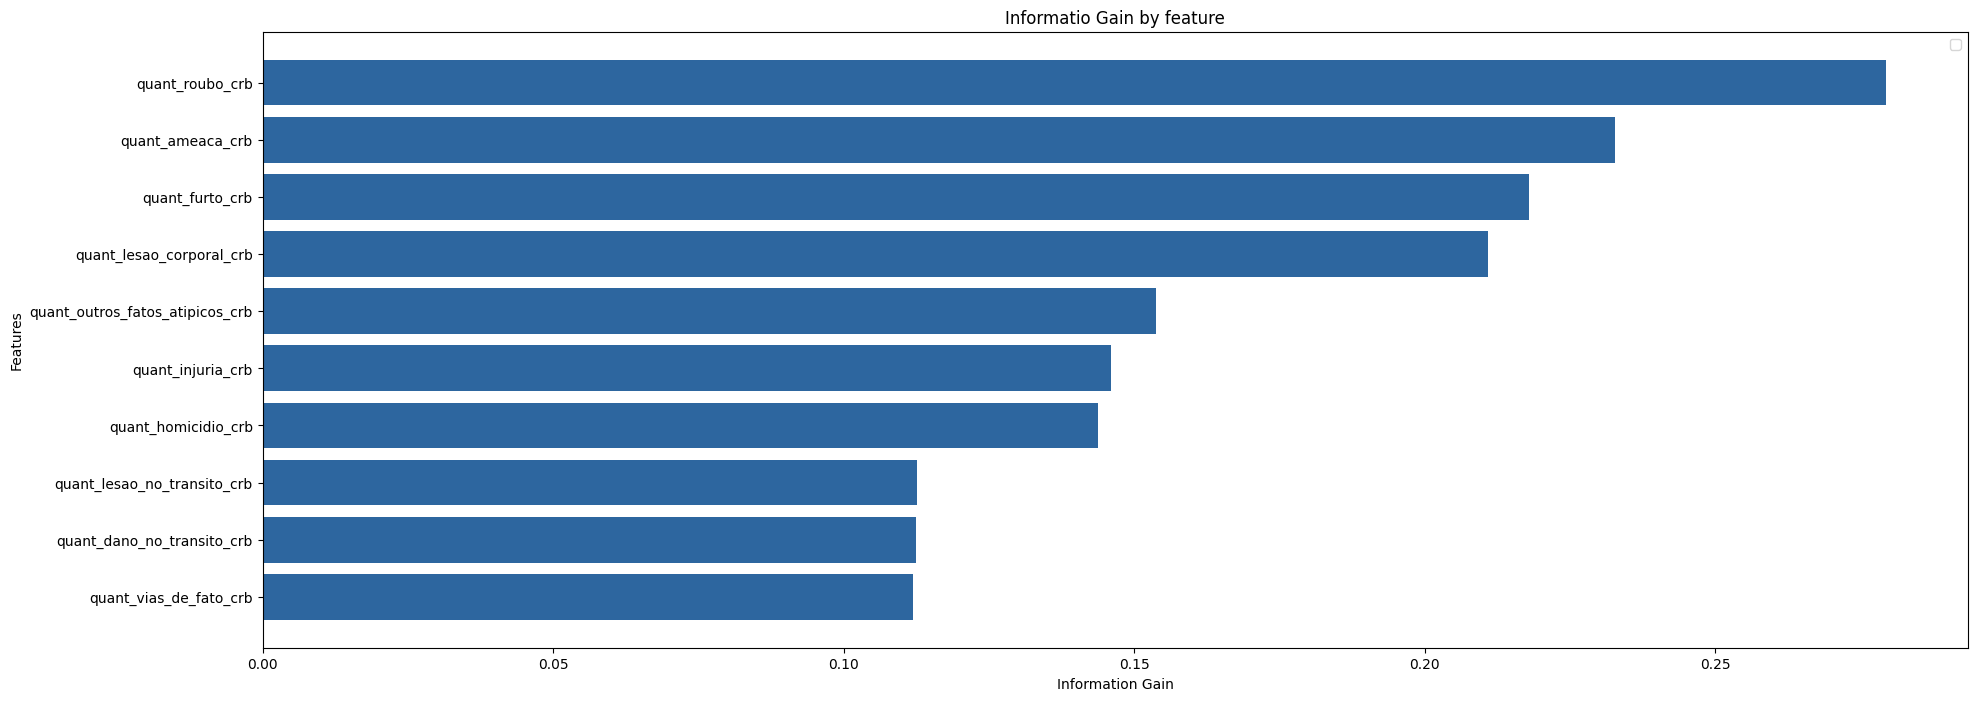

In [140]:

information_gain = pd.Series([AnalysisDefault.calcInfoGain(df_pred2town_origin,feature,y_feature_name) for feature in x_features_names], index=x_features_names).sort_values(ascending=False)

df_feature_rank['info_gain_ent'] = information_gain.index[:]

quant = 10

sns.barplot(x=information_gain[:quant], y=information_gain.index[:quant], color = (0.1, 0.4, 0.7, 0.6)) #Criando bar plot
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.title("Informatio Gain by feature")
plt.legend()
plt.autoscale(enable=True, axis='both', tight=None)
plt.show()

## Main function

In [141]:
plt.rcParams["figure.dpi"] = 100

In [142]:
def run_analysis_by_top(top_n_features_compare):
  #spearman correlation rf

  #rf
  lt_rf_shap_vs_shap = []
  lt_rf_shap_vs_eli5 = []
  lt_rf_shap_vs_dalex = []
  lt_rf_shap_vs_ci = []
  lt_rf_shap_vs_skater = []
  lt_rf_shap_vs_lofo = []
  lt_rf_shap_vs_human_1 = []
  lt_rf_shap_vs_human_2 = []
  lt_rf_shap_vs_human_3 = []
  lt_rf_shap_vs_human_4 = []
  lt_rf_shap_vs_human_5 = []
  lt_rf_shap_vs_human_6 = []

  lt_rf_eli5_vs_eli5 = []
  lt_rf_eli5_vs_dalex = []
  lt_rf_eli5_vs_ci = []
  lt_rf_eli5_vs_skater = []
  lt_rf_eli5_vs_lofo = []
  lt_rf_eli5_vs_human_1 = []
  lt_rf_eli5_vs_human_2 = []
  lt_rf_eli5_vs_human_3 = []
  lt_rf_eli5_vs_human_4 = []
  lt_rf_eli5_vs_human_5 = []
  lt_rf_eli5_vs_human_6 = []

  lt_rf_dalex_vs_dalex = []
  lt_rf_dalex_vs_ci = []
  lt_rf_dalex_vs_skater = []
  lt_rf_dalex_vs_lofo = []
  lt_rf_dalex_vs_human_1 = []
  lt_rf_dalex_vs_human_2 = []
  lt_rf_dalex_vs_human_3 = []
  lt_rf_dalex_vs_human_4 = []
  lt_rf_dalex_vs_human_5 = []
  lt_rf_dalex_vs_human_6 = []

  lt_rf_ci_vs_ci = []
  lt_rf_ci_vs_skater = []
  lt_rf_ci_vs_lofo = []
  lt_rf_ci_vs_human_1 = []
  lt_rf_ci_vs_human_2 = []
  lt_rf_ci_vs_human_3 = []
  lt_rf_ci_vs_human_4 = []
  lt_rf_ci_vs_human_5 = []
  lt_rf_ci_vs_human_6 = []

  lt_rf_skater_vs_skater = []
  lt_rf_skater_vs_lofo = []
  lt_rf_skater_vs_human_1 = []
  lt_rf_skater_vs_human_2 = []
  lt_rf_skater_vs_human_3 = []
  lt_rf_skater_vs_human_4 = []
  lt_rf_skater_vs_human_5 = []
  lt_rf_skater_vs_human_6 = []

  lt_rf_lofo_vs_lofo = []
  lt_rf_lofo_vs_human_1 = []
  lt_rf_lofo_vs_human_2 = []
  lt_rf_lofo_vs_human_3 = []
  lt_rf_lofo_vs_human_4 = []
  lt_rf_lofo_vs_human_5 = []
  lt_rf_lofo_vs_human_6 = []

  lt_rf_human_1_vs_human_1 = []
  lt_rf_human_1_vs_human_2 = []
  lt_rf_human_1_vs_human_3 = []
  lt_rf_human_1_vs_human_4 = []
  lt_rf_human_1_vs_human_5 = []
  lt_rf_human_1_vs_human_6 = []

  lt_rf_human_2_vs_human_2 = []
  lt_rf_human_2_vs_human_3 = []
  lt_rf_human_2_vs_human_4 = []
  lt_rf_human_2_vs_human_5 = []
  lt_rf_human_2_vs_human_6 = []

  lt_rf_human_3_vs_human_3 = []
  lt_rf_human_3_vs_human_4 = []
  lt_rf_human_3_vs_human_5 = []
  lt_rf_human_3_vs_human_6 = []

  lt_rf_human_4_vs_human_4 = []
  lt_rf_human_4_vs_human_5 = []
  lt_rf_human_4_vs_human_6 = []

  lt_rf_human_5_vs_human_5 = []
  lt_rf_human_5_vs_human_6 = []

  lt_rf_human_6_vs_human_6 = []


  dt = {'tool':['tshap_rf','eli5_rf','dalex_rf','ci_rf','skater_rf','lofo_rf','human_1','human_2','human_3','human_4','human_5','human_6'],
        'tshap_rf':[0,0,0,0,0,0,0,0,0,0,0,0],
        'eli5_rf':[0,0,0,0,0,0,0,0,0,0,0,0],
        'dalex_rf':[0,0,0,0,0,0,0,0,0,0,0,0],
        'ci_rf':[0,0,0,0,0,0,0,0,0,0,0,0],
        'skater_rf':[0,0,0,0,0,0,0,0,0,0,0,0],
        'lofo_rf':[0,0,0,0,0,0,0,0,0,0,0,0],
        'human_1':[0,0,0,0,0,0,0,0,0,0,0,0],
        'human_2':[0,0,0,0,0,0,0,0,0,0,0,0],
        'human_3':[0,0,0,0,0,0,0,0,0,0,0,0],
        'human_4':[0,0,0,0,0,0,0,0,0,0,0,0],
        'human_5':[0,0,0,0,0,0,0,0,0,0,0,0],
        'human_6':[0,0,0,0,0,0,0,0,0,0,0,0]
        }

  df_spearman_correlations_rf = pd.DataFrame(dt)
  df_spearman_correlations_rf = df_spearman_correlations_rf.set_index('tool')

  df_spearman_p_rf = pd.DataFrame(dt)
  df_spearman_p_rf = df_spearman_p_rf.set_index('tool')


  for i1, d1 in enumerate(df_spearman_correlations_rf.columns.to_list()):
    for i2, d2 in enumerate(df_spearman_correlations_rf.columns.to_list()):

        r1 = []
        r2 = []
        if d1.find('human') != -1:
          r1 = list(df_feature_rank[d1][:top_n_features_compare])
        if d2.find('human') != -1:
          r2 = list(df_feature_rank[d2][:top_n_features_compare])

        if d1.find('human') == -1:
          r1 = list(df_feature_rank[d1][:])
        if d2.find('human') == -1:
          r2 = list(df_feature_rank[d2][:])

        if d1.find('human') and d2.find('human'):
          r1 = Util.intersection(r1,r2)
          r2 = Util.intersection(r2,r1)


        r1, r2 = Util.repareSizeNew(r1, r2)

        #print('Comparando... ', str(d1),' e ', str(d2))
        #print('Tamanho: ',len(r1))
        #print('Tamanho: ',len(r2))


        df_spearman_correlations_rf.at[d1,d2], df_spearman_p_rf.at[d1,d2] =  AnalysisDefault.calcSpearmanCoef(r1, r2)

        if d1.find('shap') != -1 and d2.find('shap') != -1:
          lt_rf_shap_vs_shap.append(df_spearman_correlations_rf.loc[d1,d2])
        else:
          if d1.find('shap') != -1 and d2.find('eli5') != -1:
            lt_rf_shap_vs_eli5.append(df_spearman_correlations_rf.loc[d1,d2])
          else:
            if d1.find('shap') != -1 and d2.find('dalex') != -1:
              lt_rf_shap_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
            else:
              if d1.find('shap') != -1 and d2.find('ci') != -1:
                lt_rf_shap_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
              else:
                if d1.find('shap') != -1 and d2.find('skater') != -1:
                  lt_rf_shap_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                else:
                  if d1.find('shap') != -1 and d2.find('lofo') != -1:
                    lt_rf_shap_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                  else:
                    if d1.find('shap') != -1 and d2.find('human_1') != -1:
                      lt_rf_shap_vs_human_1.append(df_spearman_correlations_rf.loc[d1,d2])
                    else:
                      if d1.find('shap') != -1 and d2.find('human_2') != -1:
                        lt_rf_shap_vs_human_2.append(df_spearman_correlations_rf.loc[d1,d2])
                      else:
                        if d1.find('shap') != -1 and d2.find('human_3') != -1:
                          lt_rf_shap_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                        else:
                          if d1.find('shap') != -1 and d2.find('human_4') != -1:
                            lt_rf_shap_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                          else:
                            if d1.find('shap') != -1 and d2.find('human_5') != -1:
                              lt_rf_shap_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                            else:
                              if d1.find('shap') != -1 and d2.find('human_6') != -1:
                                lt_rf_shap_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                              else:
                                if d1.find('eli5') != -1 and d2.find('eli5') != -1:
                                  lt_rf_eli5_vs_eli5.append(df_spearman_correlations_rf.loc[d1,d2])
                                else:
                                  if d1.find('eli5') != -1 and d2.find('dalex') != -1:
                                    lt_rf_eli5_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
                                  else:
                                    if d1.find('eli5') != -1 and d2.find('ci') != -1:
                                      lt_rf_eli5_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                                    else:
                                      if d1.find('eli5') != -1 and d2.find('skater') != -1:
                                        lt_rf_eli5_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                      else:
                                        if d1.find('eli5') != -1 and d2.find('lofo') != -1:
                                          lt_rf_eli5_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                        else:
                                          if d1.find('eli5') != -1 and d2.find('human_1') != -1:
                                            lt_rf_eli5_vs_human_1.append(df_spearman_correlations_rf.loc[d1,d2])
                                          else:
                                            if d1.find('eli5') != -1 and d2.find('human_2') != -1:
                                              lt_rf_eli5_vs_human_2.append(df_spearman_correlations_rf.loc[d1,d2])
                                            else:
                                              if d1.find('eli5') != -1 and d2.find('human_3') != -1:
                                                lt_rf_eli5_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                                              else:
                                                if d1.find('eli5') != -1 and d2.find('human_4') != -1:
                                                  lt_rf_eli5_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                else:
                                                  if d1.find('eli5') != -1 and d2.find('human_5') != -1:
                                                    lt_rf_eli5_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                  else:
                                                    if d1.find('eli5') != -1 and d2.find('human_6') != -1:
                                                      lt_rf_eli5_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                    else:
                                                      if d1.find('dalex') != -1 and d2.find('dalex') != -1:
                                                        lt_rf_dalex_vs_dalex.append(df_spearman_correlations_rf.loc[d1,d2])
                                                      else:
                                                        if d1.find('dalex') != -1 and d2.find('ci') != -1:
                                                          lt_rf_dalex_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                                                        else:
                                                          if d1.find('dalex') != -1 and d2.find('skater') != -1:
                                                            lt_rf_dalex_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                                          else:
                                                            if d1.find('dalex') != -1 and d2.find('lofo') != -1:
                                                              lt_rf_dalex_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                            else:
                                                              if d1.find('dalex') != -1 and d2.find('human_1') != -1:
                                                                lt_rf_dalex_vs_human_1.append(df_spearman_correlations_rf.loc[d1,d2])
                                                              else:
                                                                if d1.find('dalex') != -1 and d2.find('human_2') != -1:
                                                                  lt_rf_dalex_vs_human_2.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                else:
                                                                  if d1.find('dalex') != -1 and d2.find('human_3') != -1:
                                                                    lt_rf_dalex_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                  else:
                                                                    if d1.find('dalex') != -1 and d2.find('human_4') != -1:
                                                                      lt_rf_dalex_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                    else:
                                                                      if d1.find('dalex') != -1 and d2.find('human_5') != -1:
                                                                        lt_rf_dalex_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                      else:
                                                                        if d1.find('dalex') != -1 and d2.find('human_6') != -1:
                                                                          lt_rf_dalex_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                        else:
                                                                          if d1.find('ci') != -1 and d2.find('ci') != -1:
                                                                            lt_rf_ci_vs_ci.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                          else:
                                                                            if d1.find('ci') != -1 and d2.find('skater') != -1:
                                                                              lt_rf_ci_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                            else:
                                                                              if d1.find('ci') != -1 and d2.find('lofo') != -1:
                                                                                lt_rf_ci_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                              else:
                                                                                if d1.find('ci') != -1 and d2.find('human_1') != -1:
                                                                                  lt_rf_ci_vs_human_1.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                else:
                                                                                  if d1.find('ci') != -1 and d2.find('human_2') != -1:
                                                                                    lt_rf_ci_vs_human_2.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                  else:
                                                                                    if d1.find('ci') != -1 and d2.find('human_3') != -1:
                                                                                      lt_rf_ci_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                    else:
                                                                                      if d1.find('ci') != -1 and d2.find('human_4') != -1:
                                                                                        lt_rf_ci_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                      else:
                                                                                        if d1.find('ci') != -1 and d2.find('human_5') != -1:
                                                                                          lt_rf_ci_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                        else:
                                                                                          if d1.find('ci') != -1 and d2.find('human_6') != -1:
                                                                                            lt_rf_ci_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                          else:
                                                                                            if d1.find('skater') != -1 and d2.find('skater') != -1:
                                                                                              lt_rf_skater_vs_skater.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                            else:
                                                                                              if d1.find('skater') != -1 and d2.find('lofo') != -1:
                                                                                                lt_rf_skater_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                              else:
                                                                                                if d1.find('skater') != -1 and d2.find('human_1') != -1:
                                                                                                  lt_rf_skater_vs_human_1.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                else:
                                                                                                  if d1.find('skater') != -1 and d2.find('human_2') != -1:
                                                                                                    lt_rf_skater_vs_human_2.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                  else:
                                                                                                    if d1.find('skater') != -1 and d2.find('human_3') != -1:
                                                                                                      lt_rf_skater_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                    else:
                                                                                                      if d1.find('skater') != -1 and d2.find('human_4') != -1:
                                                                                                        lt_rf_skater_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                      else:
                                                                                                        if d1.find('skater') != -1 and d2.find('human_5') != -1:
                                                                                                          lt_rf_skater_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                        else:
                                                                                                          if d1.find('skater') != -1 and d2.find('human_6') != -1:
                                                                                                            lt_rf_skater_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                          else:
                                                                                                            if d1.find('lofo') != -1 and d2.find('lofo') != -1:
                                                                                                              lt_rf_lofo_vs_lofo.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                            else:
                                                                                                              if d1.find('lofo') != -1 and d2.find('human_1') != -1:
                                                                                                                lt_rf_lofo_vs_human_1.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                              else:
                                                                                                                if d1.find('lofo') != -1 and d2.find('human_2') != -1:
                                                                                                                  lt_rf_lofo_vs_human_2.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                else:
                                                                                                                  if d1.find('lofo') != -1 and d2.find('human_3') != -1:
                                                                                                                    lt_rf_lofo_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                  else:
                                                                                                                    if d1.find('lofo') != -1 and d2.find('human_4') != -1:
                                                                                                                      lt_rf_lofo_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                    else:
                                                                                                                      if d1.find('lofo') != -1 and d2.find('human_5') != -1:
                                                                                                                        lt_rf_lofo_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                      else:
                                                                                                                        if d1.find('lofo') != -1 and d2.find('human_6') != -1:
                                                                                                                          lt_rf_lofo_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                        else:
                                                                                                                          if d1.find('human_1') != -1 and d2.find('human_1') != -1:
                                                                                                                            lt_rf_human_1_vs_human_1.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                          else:
                                                                                                                            if d1.find('human_1') != -1 and d2.find('human_2') != -1:
                                                                                                                              lt_rf_human_1_vs_human_2.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                            else:
                                                                                                                              if d1.find('human_1') != -1 and d2.find('human_3') != -1:
                                                                                                                                lt_rf_human_1_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                              else:
                                                                                                                                if d1.find('human_1') != -1 and d2.find('human_4') != -1:
                                                                                                                                  lt_rf_human_1_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                else:
                                                                                                                                  if d1.find('human_1') != -1 and d2.find('human_5') != -1:
                                                                                                                                    lt_rf_human_1_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                  else:
                                                                                                                                    if d1.find('human_1') != -1 and d2.find('human_6') != -1:
                                                                                                                                      lt_rf_human_1_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                    else:
                                                                                                                                      if d1.find('human_2') != -1 and d2.find('human_2') != -1:
                                                                                                                                        lt_rf_human_2_vs_human_2.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                      else:
                                                                                                                                        if d1.find('human_2') != -1 and d2.find('human_3') != -1:
                                                                                                                                          lt_rf_human_2_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                        else:
                                                                                                                                          if d1.find('human_2') != -1 and d2.find('human_4') != -1:
                                                                                                                                            lt_rf_human_2_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                          else:
                                                                                                                                            if d1.find('human_2') != -1 and d2.find('human_5') != -1:
                                                                                                                                              lt_rf_human_2_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                            else:
                                                                                                                                              if d1.find('human_2') != -1 and d2.find('human_6') != -1:
                                                                                                                                                lt_rf_human_2_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                              else:
                                                                                                                                                if d1.find('human_3') != -1 and d2.find('human_3') != -1:
                                                                                                                                                  lt_rf_human_3_vs_human_3.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                else:
                                                                                                                                                  if d1.find('human_3') != -1 and d2.find('human_4') != -1:
                                                                                                                                                    lt_rf_human_3_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                  else:
                                                                                                                                                    if d1.find('human_3') != -1 and d2.find('human_5') != -1:
                                                                                                                                                      lt_rf_human_3_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                    else:
                                                                                                                                                      if d1.find('human_3') != -1 and d2.find('human_6') != -1:
                                                                                                                                                        lt_rf_human_3_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                      else:
                                                                                                                                                        if d1.find('human_4') != -1 and d2.find('human_4') != -1:
                                                                                                                                                          lt_rf_human_4_vs_human_4.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                        else:
                                                                                                                                                          if d1.find('human_4') != -1 and d2.find('human_5') != -1:
                                                                                                                                                            lt_rf_human_4_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                          else:
                                                                                                                                                            if d1.find('human_4') != -1 and d2.find('human_6') != -1:
                                                                                                                                                              lt_rf_human_4_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                            else:
                                                                                                                                                              if d1.find('human_5') != -1 and d2.find('human_5') != -1:
                                                                                                                                                                lt_rf_human_5_vs_human_5.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                              else:
                                                                                                                                                                  if d1.find('human_5') != -1 and d2.find('human_6') != -1:
                                                                                                                                                                    lt_rf_human_5_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])
                                                                                                                                                                  else:
                                                                                                                                                                      if d1.find('human_6') != -1 and d2.find('human_6') != -1:
                                                                                                                                                                        lt_rf_human_6_vs_human_6.append(df_spearman_correlations_rf.loc[d1,d2])



  #plot only diagonal values
  corr =  df_spearman_correlations_rf.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))

  df_spearman_correlations_rf = df_spearman_correlations_rf.reset_index()
  minSp = -1
  maxSp = 1
  sns.heatmap(df_spearman_correlations_rf.drop(columns='tool').values,mask=mask,
              xticklabels=df_spearman_correlations_rf['tool'].values,
              yticklabels=df_spearman_correlations_rf['tool'].values,
              vmin=minSp, vmax=maxSp,cmap="Greens",
              linewidths=.5,annot=True,fmt='.1f')

  plt.show()

  minSp = 0
  maxSp = 0.1
  df_spearman_p_rf = df_spearman_p_rf.reset_index()
  sns.heatmap(df_spearman_p_rf.drop(columns='tool').values,mask=mask,
              xticklabels=df_spearman_p_rf['tool'].values,
              yticklabels=df_spearman_p_rf['tool'].values,
              vmin=minSp, vmax=maxSp,cmap="Reds_r",
              linewidths=.5,annot=True,fmt='.2f')
  plt.show()

  data_1 = lt_rf_shap_vs_shap
  data_2 = lt_rf_shap_vs_eli5
  data_3 = lt_rf_shap_vs_dalex
  data_4 = lt_rf_shap_vs_ci
  data_5 = lt_rf_shap_vs_skater
  data_6 = lt_rf_shap_vs_lofo
  data_7 = lt_rf_shap_vs_human_1
  data_8 = lt_rf_shap_vs_human_2
  data_9 = lt_rf_shap_vs_human_3
  data_10 = lt_rf_shap_vs_human_4
  data_11 = lt_rf_shap_vs_human_5
  data_12 = lt_rf_shap_vs_human_6
  data_13 = lt_rf_eli5_vs_eli5
  data_14 = lt_rf_eli5_vs_dalex
  data_15 = lt_rf_eli5_vs_ci
  data_16 = lt_rf_eli5_vs_skater
  data_17 = lt_rf_eli5_vs_lofo
  data_18 = lt_rf_eli5_vs_human_1
  data_19 = lt_rf_eli5_vs_human_2
  data_20 = lt_rf_eli5_vs_human_3
  data_21 = lt_rf_eli5_vs_human_4
  data_22 = lt_rf_eli5_vs_human_5
  data_23 = lt_rf_eli5_vs_human_6
  data_24 = lt_rf_dalex_vs_dalex
  data_25 = lt_rf_dalex_vs_ci
  data_26 = lt_rf_dalex_vs_skater
  data_27 = lt_rf_dalex_vs_lofo
  data_28 = lt_rf_dalex_vs_human_1
  data_29 = lt_rf_dalex_vs_human_2
  data_30 = lt_rf_dalex_vs_human_3
  data_31 = lt_rf_dalex_vs_human_4
  data_32 = lt_rf_dalex_vs_human_5
  data_33 = lt_rf_dalex_vs_human_6
  data_34 = lt_rf_ci_vs_ci
  data_35 = lt_rf_ci_vs_skater
  data_36 = lt_rf_ci_vs_lofo
  data_37 = lt_rf_ci_vs_human_1
  data_38 = lt_rf_ci_vs_human_2
  data_39 = lt_rf_ci_vs_human_3
  data_40 = lt_rf_ci_vs_human_4
  data_41 = lt_rf_ci_vs_human_5
  data_42 = lt_rf_ci_vs_human_6
  data_43 = lt_rf_skater_vs_skater
  data_44 = lt_rf_skater_vs_lofo
  data_45 = lt_rf_skater_vs_human_1
  data_46 = lt_rf_skater_vs_human_2
  data_47 = lt_rf_skater_vs_human_3
  data_48 = lt_rf_skater_vs_human_4
  data_49 = lt_rf_skater_vs_human_5
  data_50 = lt_rf_skater_vs_human_6
  data_51 = lt_rf_lofo_vs_lofo
  data_52 = lt_rf_lofo_vs_human_1
  data_53 = lt_rf_lofo_vs_human_2
  data_54 = lt_rf_lofo_vs_human_3
  data_55 = lt_rf_lofo_vs_human_4
  data_56 = lt_rf_lofo_vs_human_5
  data_57 = lt_rf_lofo_vs_human_6
  data_58 = lt_rf_human_1_vs_human_1
  data_59 = lt_rf_human_1_vs_human_2
  data_60 = lt_rf_human_1_vs_human_3
  data_61 = lt_rf_human_1_vs_human_4
  data_62 = lt_rf_human_1_vs_human_5
  data_63 = lt_rf_human_1_vs_human_6
  data_64 = lt_rf_human_2_vs_human_2
  data_65 = lt_rf_human_2_vs_human_3
  data_66 = lt_rf_human_2_vs_human_4
  data_67 = lt_rf_human_2_vs_human_5
  data_68 = lt_rf_human_2_vs_human_6
  data_69 = lt_rf_human_3_vs_human_3
  data_70 = lt_rf_human_3_vs_human_4
  data_71 = lt_rf_human_3_vs_human_5
  data_72 = lt_rf_human_3_vs_human_6
  data_73 = lt_rf_human_4_vs_human_4
  data_74 = lt_rf_human_4_vs_human_5
  data_75 = lt_rf_human_4_vs_human_6
  data_76 = lt_rf_human_5_vs_human_5
  data_77 = lt_rf_human_5_vs_human_6
  data_78 = lt_rf_human_6_vs_human_6






  dt = {#'shap vs shap': data_1[:],
        'ME: shap vs ME: eli5': data_2[:],
        'ME: shap vs ME: dalex': data_3[:],
        'ME: shap vs ME: ci': data_4[:],
        'ME: shap vs ME: skater': data_5[:],
        'ME: shap vs ME: lofo': data_6[:],
        'ME: shap vs IE: human 1': data_7[:],
        'ME: shap vs IE: human 2': data_8[:],
        'ME: shap vs IE: human 3': data_9[:],
        'ME: shap vs IE: human 4': data_10[:],
        'ME: shap vs IE: human 5': data_11[:],
        'ME: shap vs IE: human 6': data_12[:],
        #'eli5 vs eli5': data_13[:],
        'ME: eli5 vs ME: dalex': data_14[:],
        'ME: eli5 vs ME: ci': data_15[:],
        'ME: eli5 vs ME: skater': data_16[:],
        'ME: eli5 vs ME: lofo': data_17[:],
        'ME: eli5 vs IE: human 1': data_18[:],
        'ME: eli5 vs IE: human 2': data_19[:],
        'ME: eli5 vs IE: human 3': data_20[:],
        'ME: eli5 vs IE: human 4': data_21[:],
        'ME: eli5 vs IE: human 5': data_22[:],
        'ME: eli5 vs IE: human 6': data_23[:],
        #'dalex vs dalex': data_24[:],
        'ME: dalex vs ME: ci': data_25[:],
        'ME: dalex vs ME: skater': data_26[:],
        'ME: dalex vs ME: lofo': data_27[:],
        'ME: dalex vs IE: human 1': data_28[:],
        'ME: dalex vs IE: human 2': data_29[:],
        'ME: dalex vs IE: human 3': data_30[:],
        'ME: dalex vs IE: human 4': data_31[:],
        'ME: dalex vs IE: human 5': data_32[:],
        'ME: dalex vs IE: human 6': data_33[:],
        #'ci vs ci': data_34[:],
        'ME: ci vs ME: skater': data_35[:],
        'ME: ci vs ME: lofo': data_36[:],
        'ME: ci vs IE: human 1': data_37[:],
        'ME: ci vs IE: human 2': data_38[:],
        'ME: ci vs IE: human 3': data_39[:],
        'ME: ci vs IE: human 4': data_40[:],
        'ME: ci vs IE: human 5': data_41[:],
        'ME: ci vs IE: human 6': data_42[:],
        #'skater vs skater': data_43[:],
        'ME: skater vs ME: lofo': data_44[:],
        'ME: skater vs IE: human 1': data_45[:],
        'ME: skater vs IE: human 2': data_46[:],
        'ME: skater vs IE: human 3': data_47[:],
        'ME: skater vs IE: human 4': data_48[:],
        'ME: skater vs IE: human 5': data_49[:],
        'ME: skater vs IE: human 6': data_50[:],
        #'lofo vs lofo': data_51[:],
        'ME: lofo vs IE: human 1': data_52[:],
        'ME: lofo vs IE: human 2': data_53[:],
        'ME: lofo vs IE: human 3': data_54[:],
        'ME: lofo vs IE: human 4': data_55[:],
        'ME: lofo vs IE: human 5': data_56[:],
        'ME: lofo vs IE: human 6': data_57[:],
        #'human 1 vs human 1': data_58[:],
        'IE: human 1 vs IE: human 2': data_59[:],
        'IE: human 1 vs IE: human 3': data_60[:],
        'IE: human 1 vs IE: human 4': data_61[:],
        'IE: human 1 vs IE: human 5': data_62[:],
        'IE: human 1 vs IE: human 6': data_63[:],
        #'human 2 vs human 2': data_64[:],
        'IE: human 2 vs IE: human 3': data_65[:],
        'IE: human 2 vs IE: human 4': data_66[:],
        'IE: human 2 vs IE: human 5': data_67[:],
        'IE: human 2 vs IE: human 6': data_68[:],
        #'human 3 vs human 3': data_69[:],
        'IE: human 3 vs IE: human 4': data_70[:],
        'IE: human 3 vs IE: human 5': data_71[:],
        'IE: human 3 vs IE: human 6': data_72[:],
        #'human 4 vs human 4': data_73[:],
        'IE: human 4 vs IE: human 5': data_74[:],
        'IE: human 4 vs IE: human 6': data_75[:],
        #'human 5 vs human 5': data_76[:],
        'IE: human 5 vs IE: human 6': data_77[:]
        #'human 6 vs human 6': data_78[:]
        }

  df_boxplot = pd.DataFrame(dt)

  #Sort collumns
  list_medians = []
  for i in range(len(df_boxplot.columns)):
    #list_medians.append(statistics.median(df_boxplot.iloc[:,i].values))
    list_medians.append(statistics.median(df_boxplot.iloc[:,i].values))

  serie_medians = pd.Series(list_medians)

  serie_medians = serie_medians.sort_values()

  ys, names, xs, lc = [],[],[],[]
  val_h_vs_h, val_h_vs_ai, val_ai_vs_ai = [],[],[]
  for i, col in enumerate(df_boxplot.columns[serie_medians.index]):
      ys.append(df_boxplot[col].values)


      p1 = regex.compile('IE: human \d* vs IE: human \d*')
      m1 = p1.match(col)
      if m1:
        lc.append('red')
        val_h_vs_h.append(float(df_boxplot[col].values[0]))
      else:
        p2 = regex.compile('human')
        m2 = p2.findall(col)
        if m2:
          lc.append('blue')
          val_h_vs_ai.append(float(df_boxplot[col].values[0]))
        else:
          lc.append('green')
          val_ai_vs_ai.append(float(df_boxplot[col].values[0]))

      names.append(col)
      xs.append(i)




  fig = plt.figure(figsize=(16,(top_n_features_compare/3)+1))


  model_name = 'RF'
  plt.title("Comparison of all features ranks - Algorithm "+ model_name)


  val = statistics.stdev(val_ai_vs_ai)
  plt.axhline(val, c='g',linestyle='--',alpha=0.8)
  plt.text(17,val+0.05,'Standard deviation of ME vs ME:'+str(round(val,2)),c='g')

  val = statistics.stdev(val_h_vs_ai)
  plt.axhline(val, c='b',linestyle='--',alpha=0.8)
  plt.text(17,val+0.05,'Standard deviation of ME vs IE:'+str(round(val,2)),c='b')

  val = statistics.stdev(val_h_vs_h)
  plt.axhline(val, c='r',linestyle='--',alpha=0.8)
  plt.text(17,val+0.05,'Standard deviation of IE vs IE:'+str(round(val,2)),c='r')

  plt.xlabel('Comparison of rank pairs')
  plt.ylabel('Spearman Correlation')

  plt.scatter(names,ys,s=100,c=lc)

  plt.yticks(np.arange(-1.1,1.1,0.1))

  plt.xticks(rotation=90)
  plt.grid(True,c='gainsboro')



## Executions

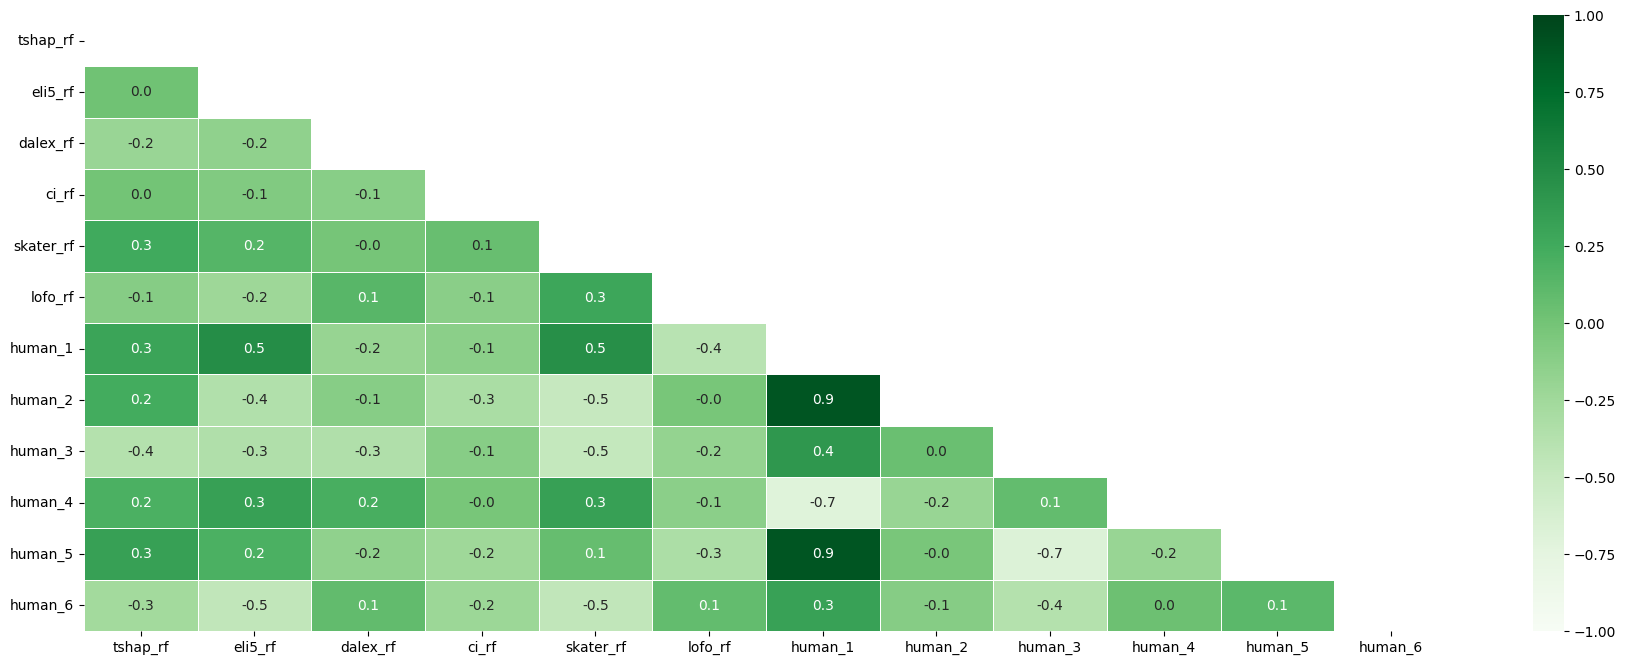

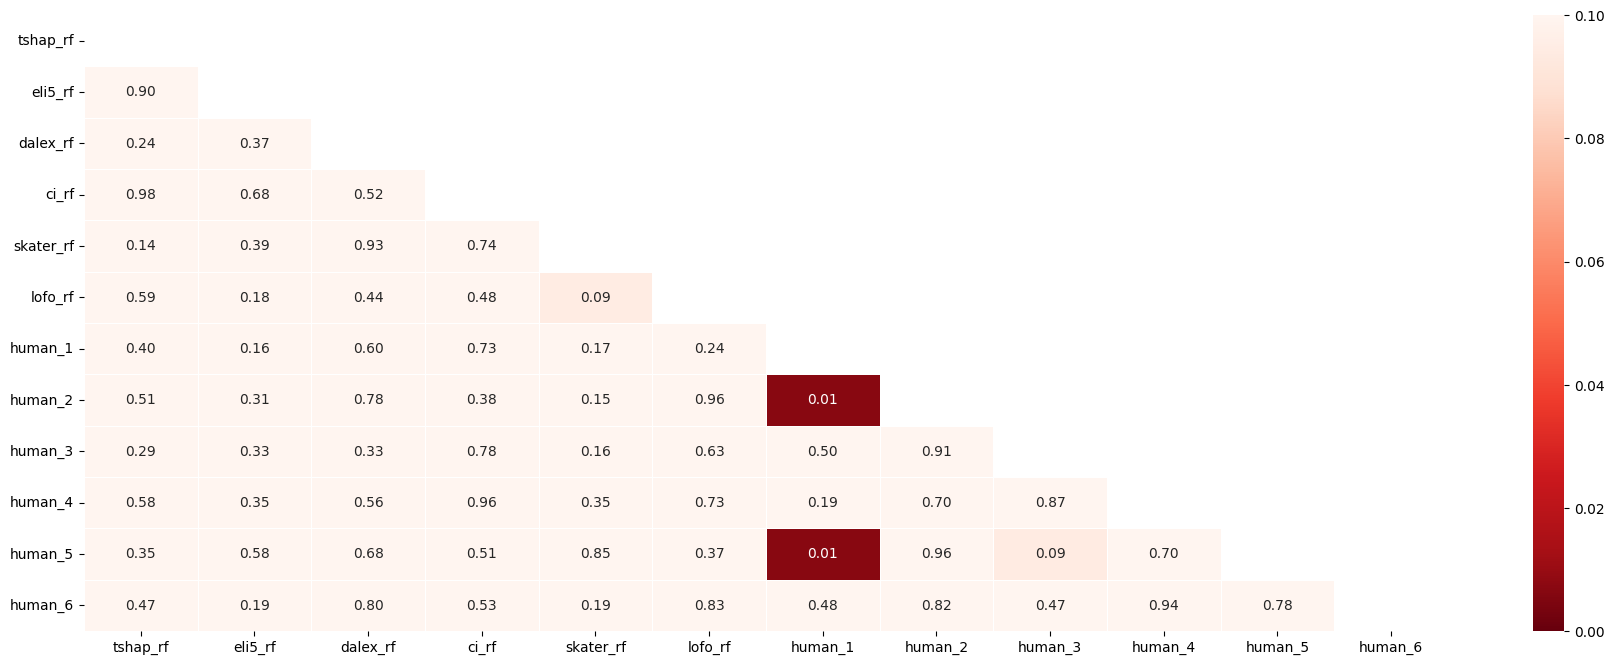

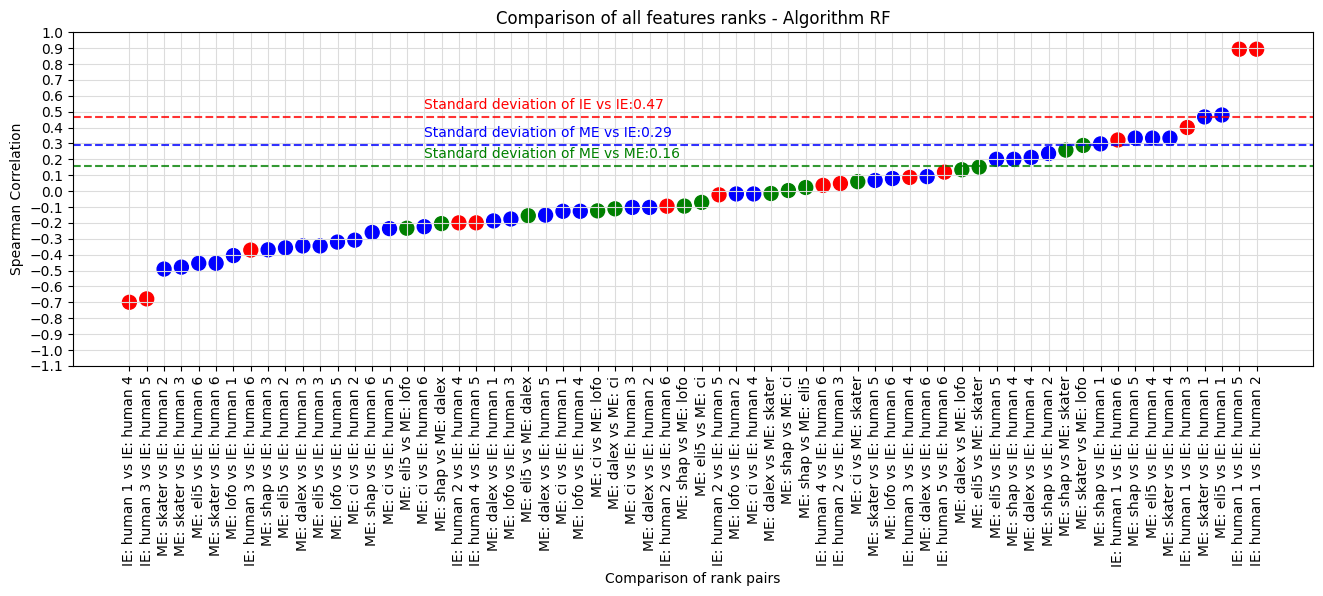

In [143]:
run_analysis_by_top(10)

Text(0.5, 1.0, 'Random Forest')

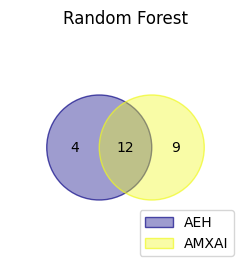

In [144]:


#from https://github.com/LankyCyril/pyvenn/blob/master/pyvenn-demo.ipynb

figure,top_axs = subplots(ncols=1, nrows=1, figsize=(3,3))



titlesize=12
labelsize=10
datasetfontsize=10

num = 10
set1 = set(list(df_feature_rank['human_1'][:num])+
           list(df_feature_rank['human_2'][:num])+
           list(df_feature_rank['human_3'][:num])+
           list(df_feature_rank['human_4'][:num])+
           list(df_feature_rank['human_5'][:num])+
           list(df_feature_rank['human_6'][:num]))

#tshap_rf	eli5_rf	dalex_rf	ci_rf	skater_rf	lofo_rf
set2 = set(list(df_feature_rank['tshap_rf'][:num])+
           list(df_feature_rank['eli5_rf'][:num])+
           list(df_feature_rank['dalex_rf'][:num])+
           list(df_feature_rank['ci_rf'][:num])+
           list(df_feature_rank['skater_rf'][:num])+
           list(df_feature_rank['lofo_rf'][:num]))

sete =  {'AEH':set1,
          'AMXAI':set2}

v = venn(sete,cmap="plasma",fontsize=labelsize,legend_loc="lower right",ax=top_axs)
v.set_title('Random Forest',fontsize=titlesize)




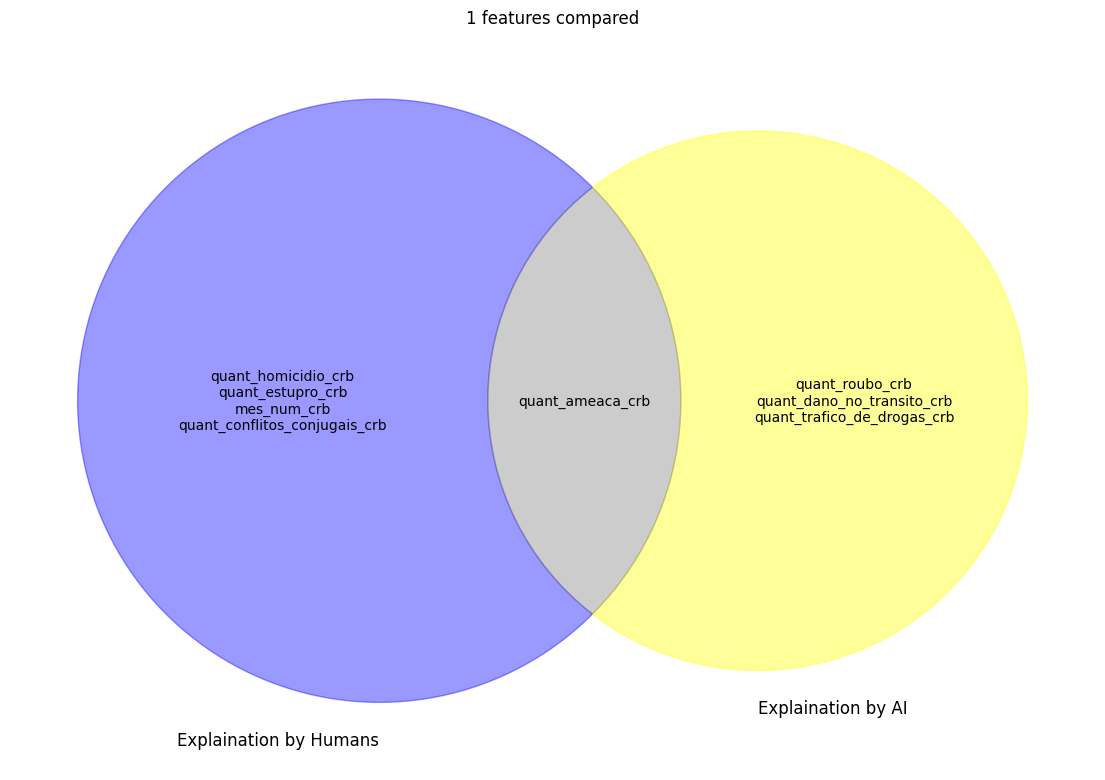

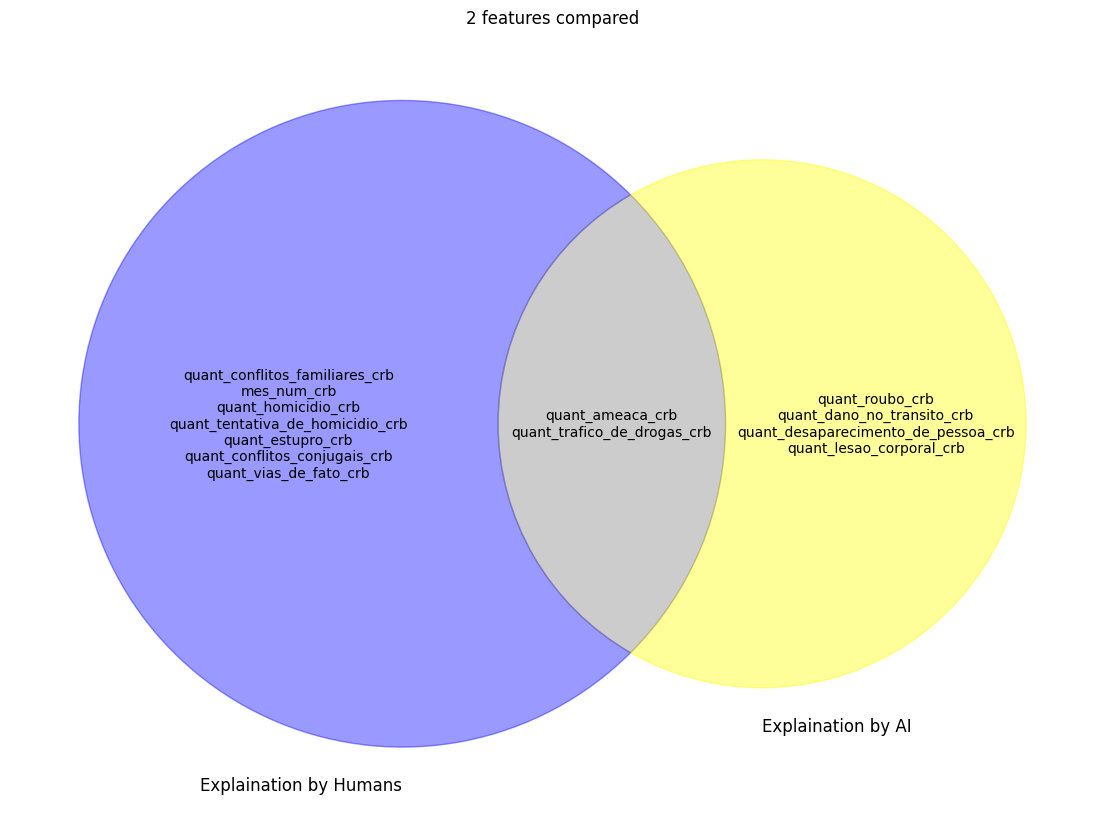

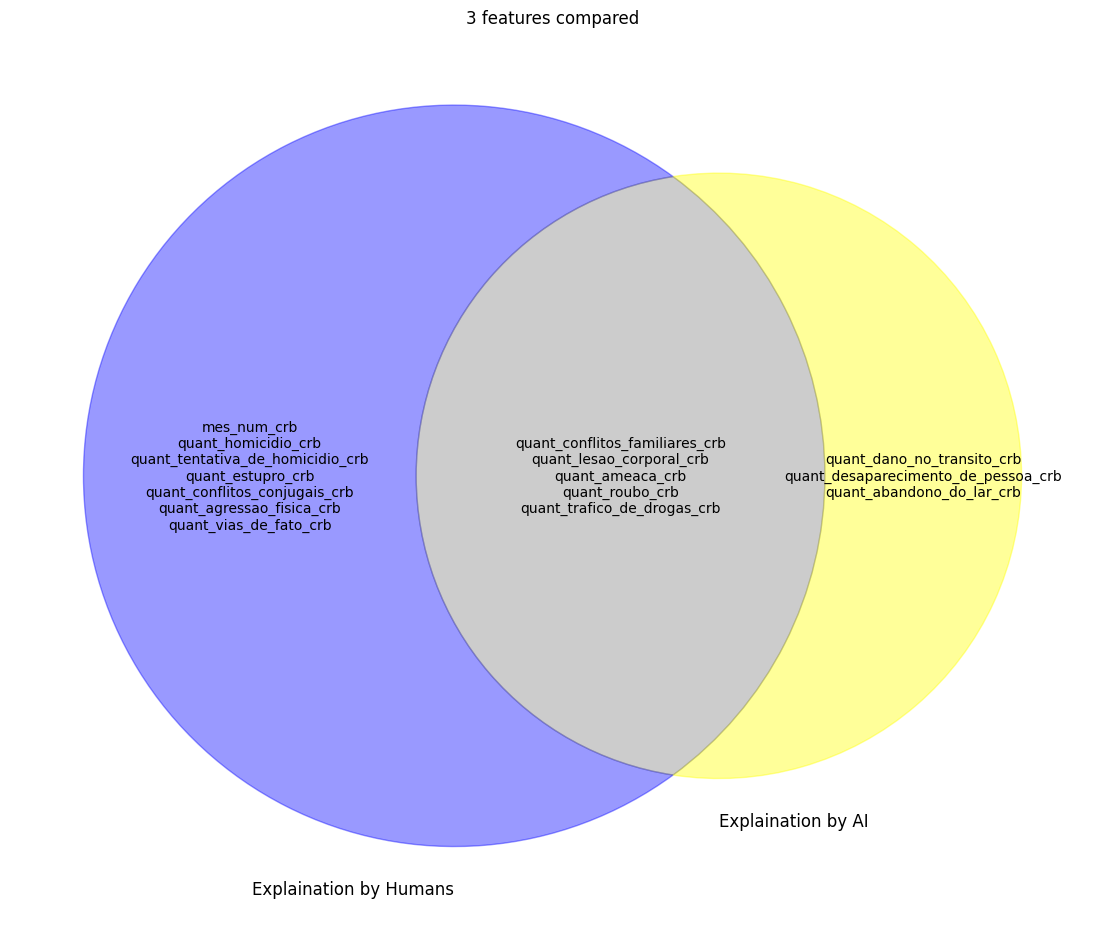

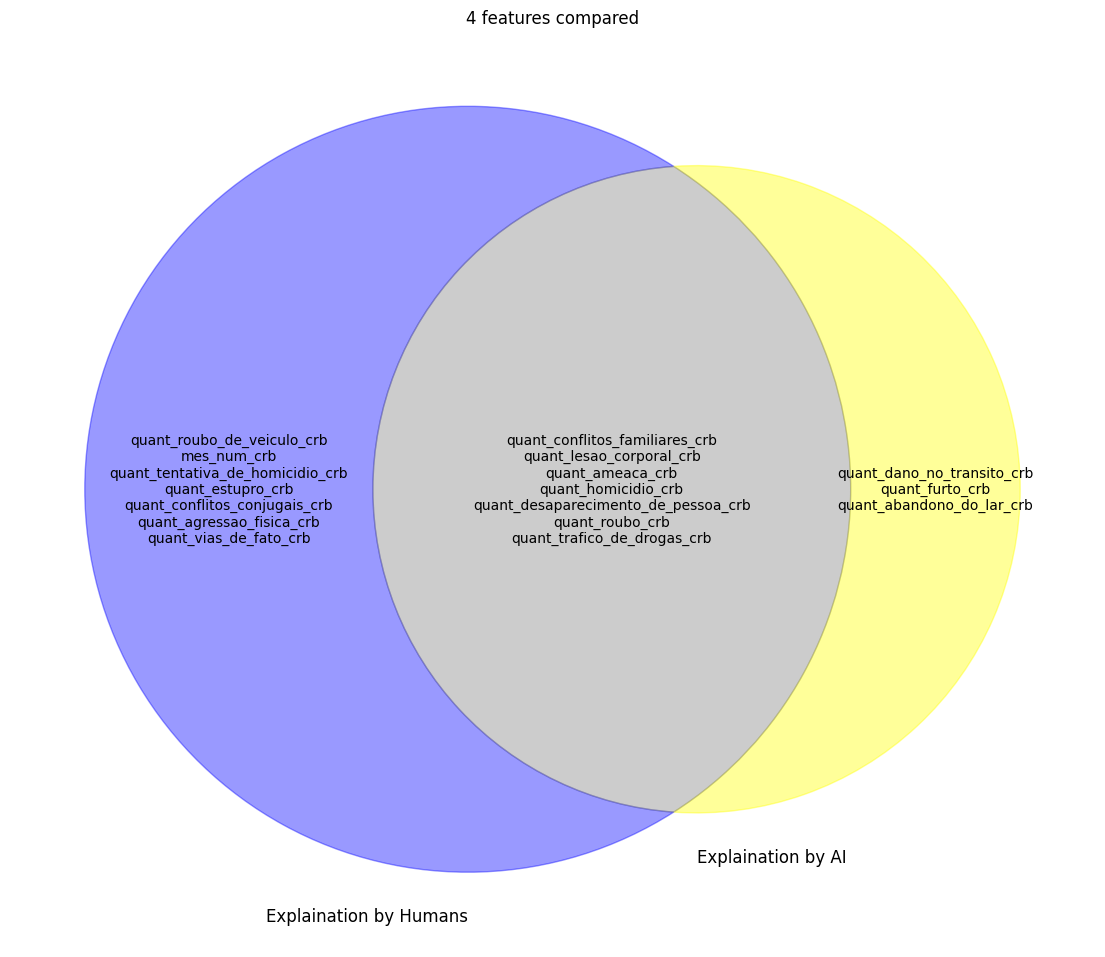

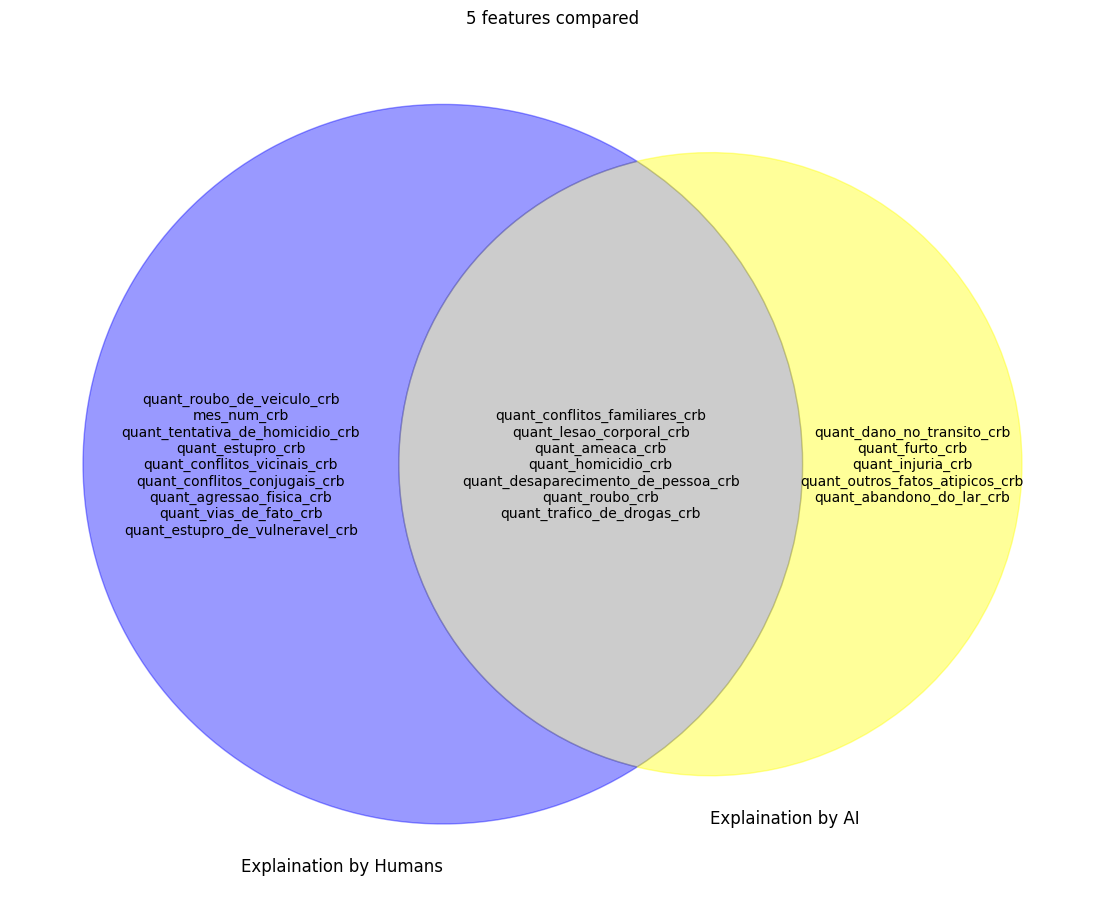

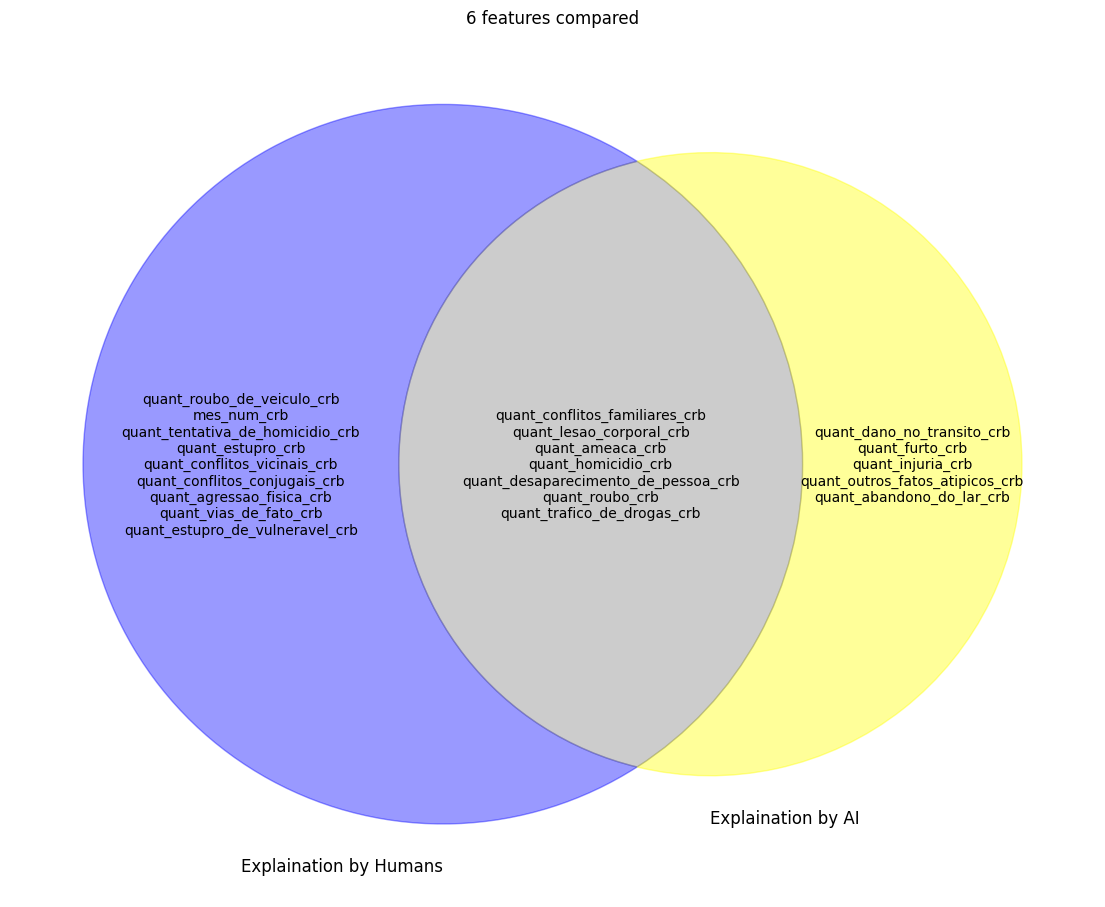

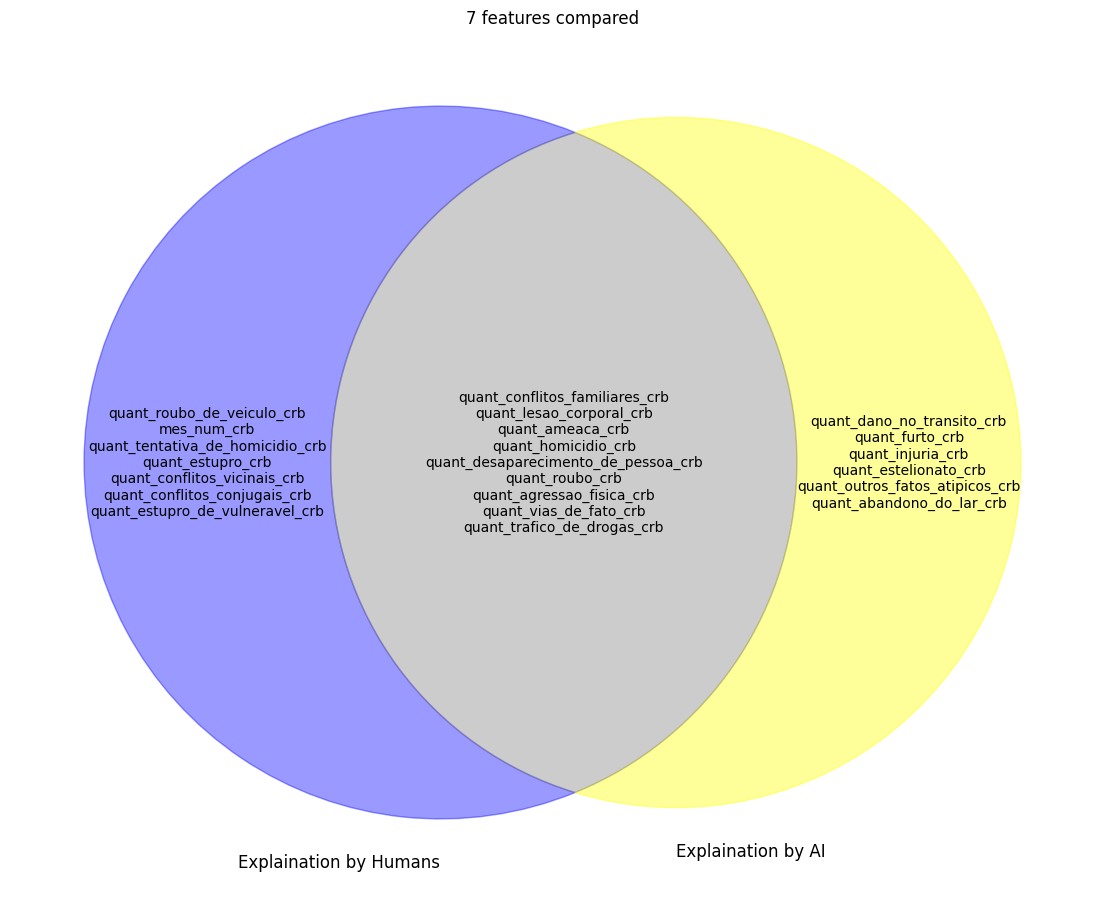

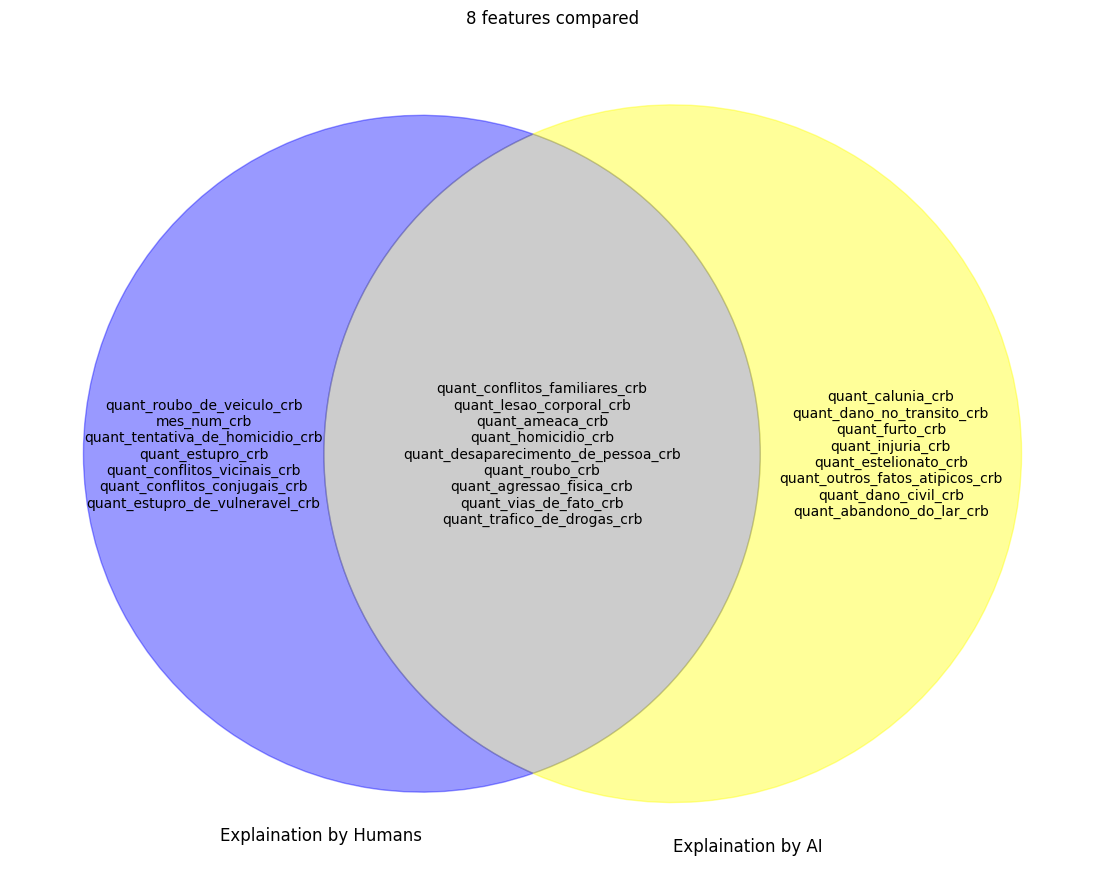

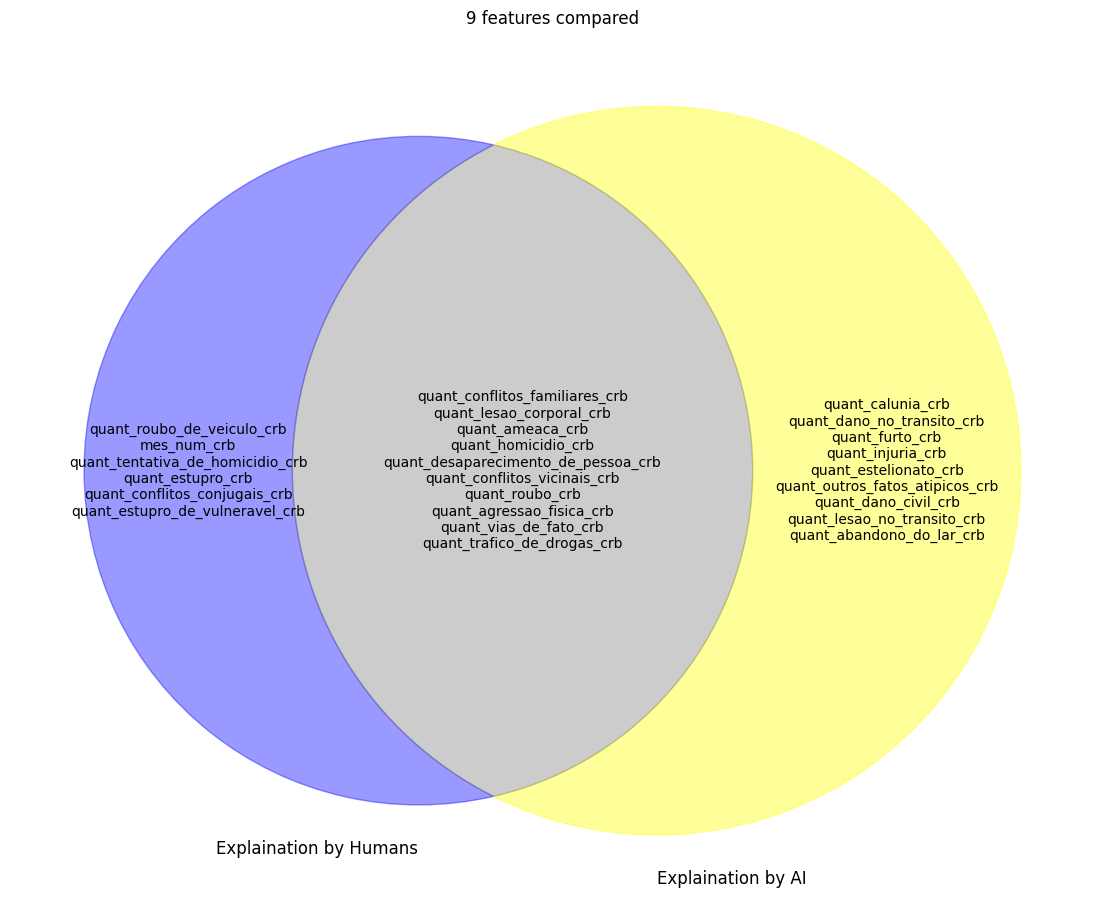

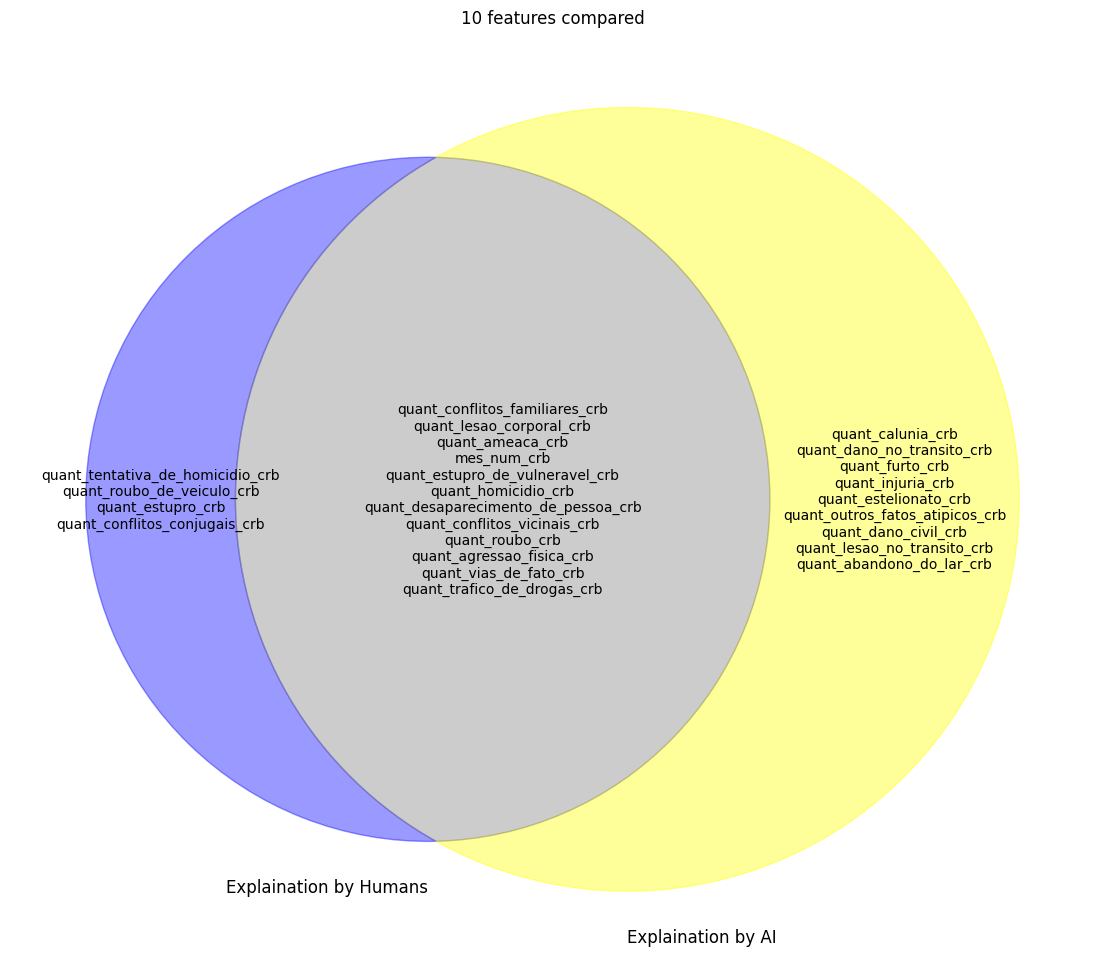

In [145]:

for i in range(1,11):
  subplots(ncols=1, nrows=1, figsize=(14,14))
  num = i
  A = set(list(df_feature_rank['human_1'][:num])+
            list(df_feature_rank['human_2'][:num])+
            list(df_feature_rank['human_3'][:num])+
            list(df_feature_rank['human_4'][:num])+
            list(df_feature_rank['human_5'][:num])+
            list(df_feature_rank['human_6'][:num]))
  B = set(list(df_feature_rank['tshap_rf'][:num])+
            list(df_feature_rank['eli5_rf'][:num])+
            list(df_feature_rank['dalex_rf'][:num])+
            list(df_feature_rank['ci_rf'][:num])+
            list(df_feature_rank['skater_rf'][:num])+
            list(df_feature_rank['lofo_rf'][:num]))


  v = venn2([A,B], ('Explaination by Humans', 'Explaination by AI'))

  ppp=v.get_label_by_id('100').set_text('\n'.join(A-B))
  v.get_label_by_id('110').set_text('\n'.join(A&B))
  v.get_label_by_id('010').set_text('\n'.join(B-A))

  v.get_patch_by_id('100').set_color('blue')
  v.get_patch_by_id('110').set_color('gray')
  v.get_patch_by_id('010').set_color('yellow')
  plt.title(str(i)+' features compared')
  plt.show()
  print("")
  print("")
  print("")

<BarContainer object of 35 artists>

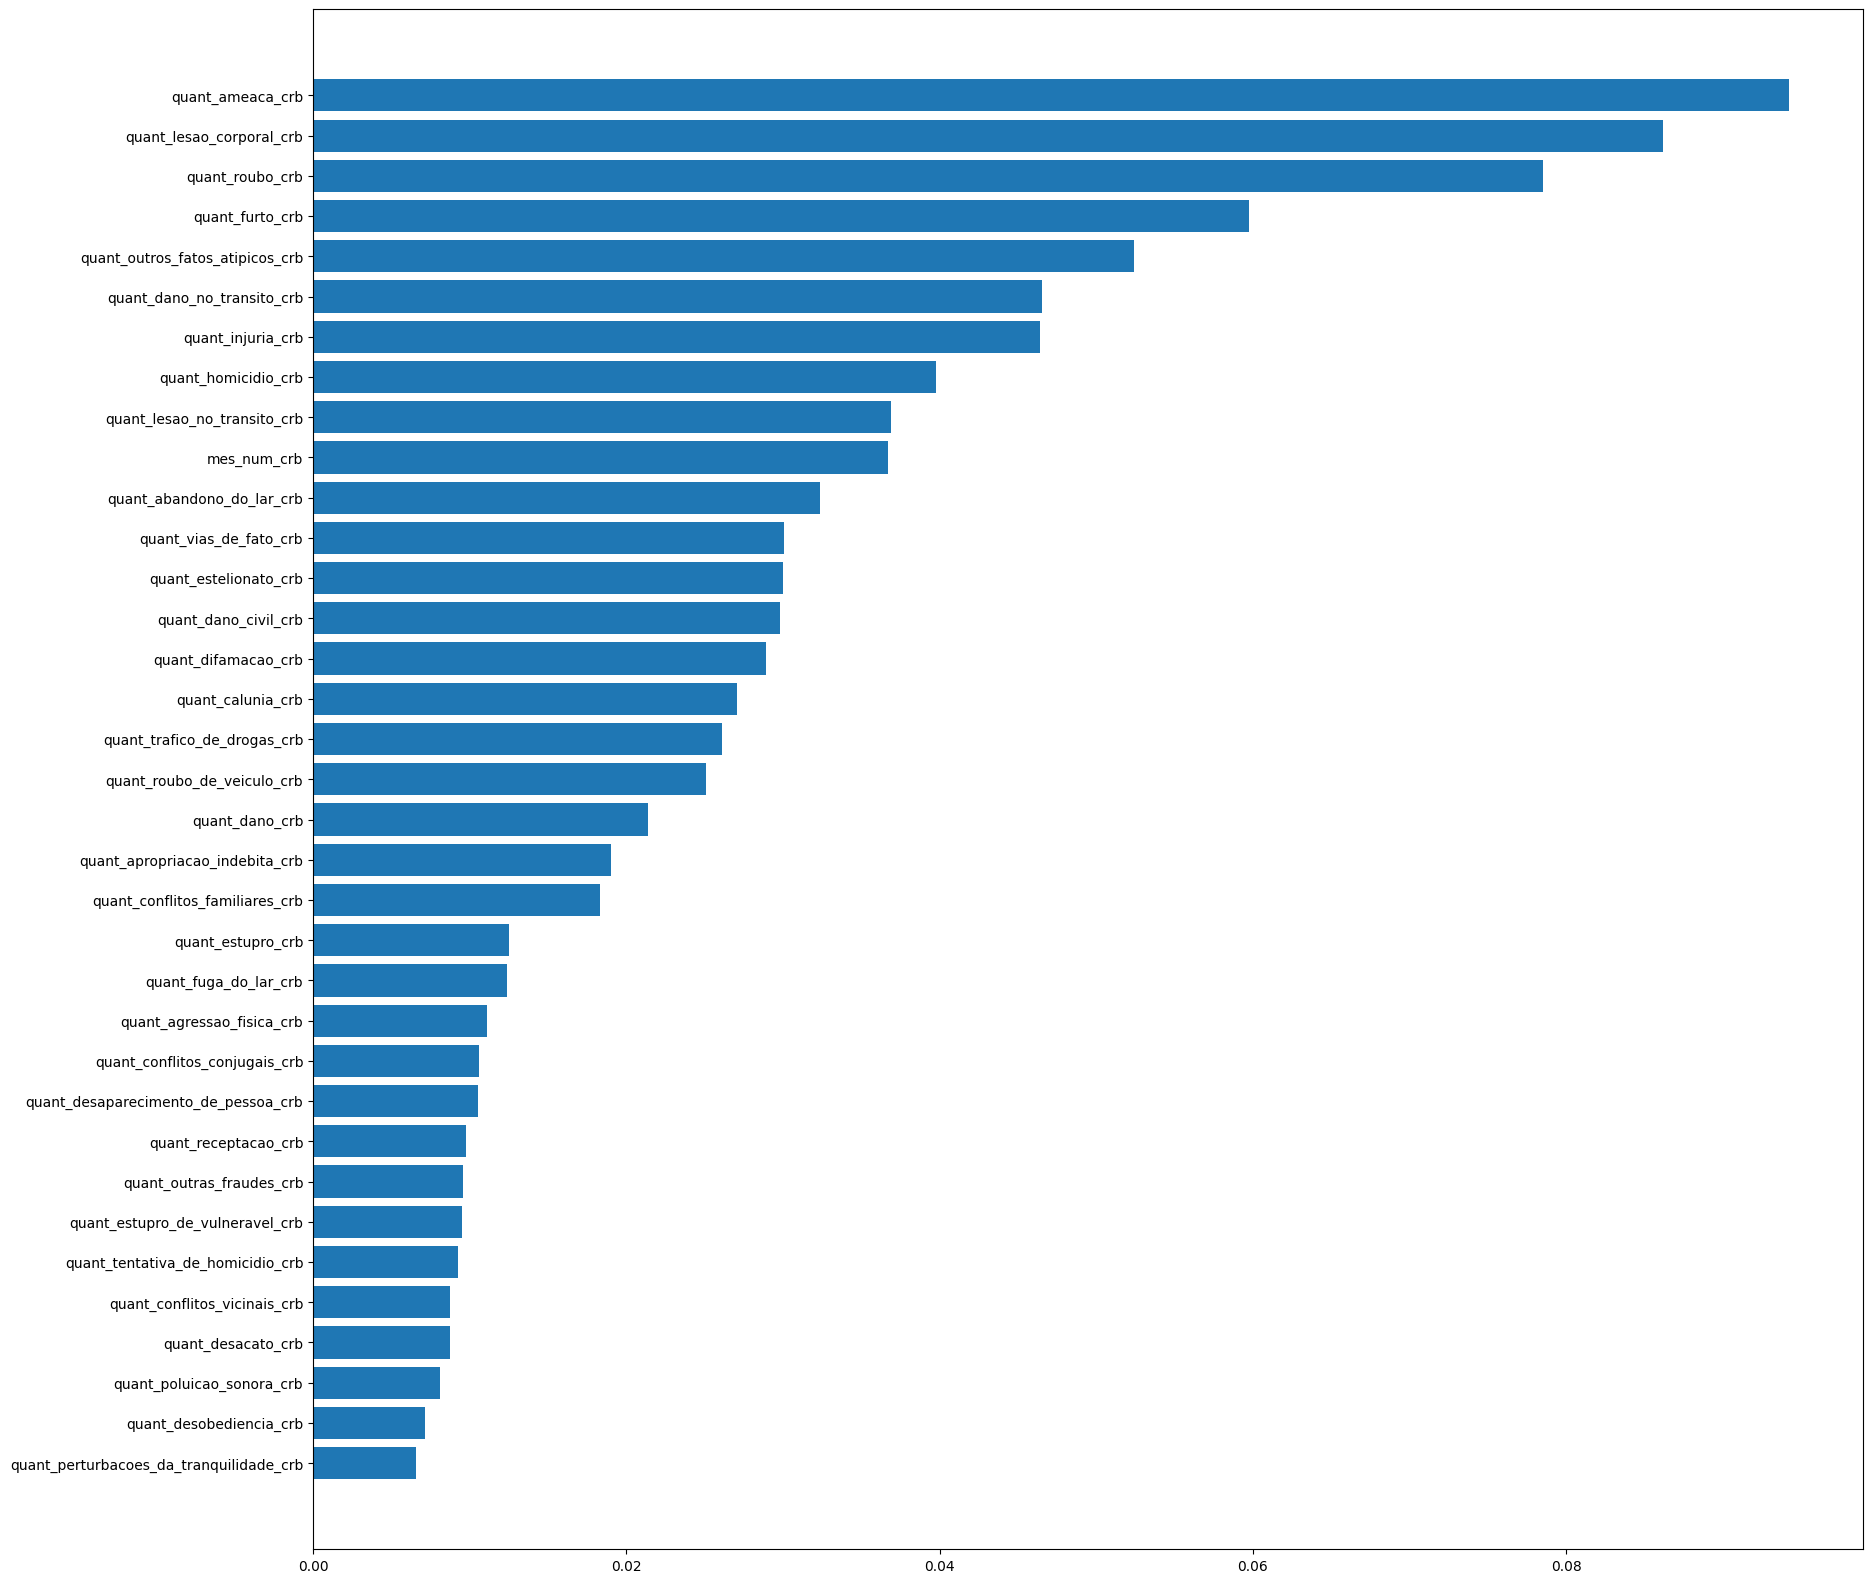

In [146]:
plt.figure(figsize=(20,20))
features_importances = pd.Series(model_rf.feature_importances_)
features_names = pd.Series(x_features_names)
features_importances = features_importances.sort_values()
plt.barh(features_names[features_importances.index],features_importances)

In [147]:
if do_download_files == True:
  name_fig = "fig_spearman_coeficients_matrix_"+dataset_name+"_rf.png"
  plt.savefig(name_fig)
  files.download(name_fig)
plt.show()


if do_download_files == True:
  name = 'df_models_info.csv'
  df_models_info.to_csv(name)
  files.download(name)

if do_download_files == True:
  name = 'df_feature_rank.csv'
  df_feature_rank.to_csv(name)
  files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 2200x800 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [148]:
df_features_rank_copy = df_feature_rank.copy()
features = df_features_rank_copy['att_original_names']
#df_features_rank_copy = df_features_rank_copy.drop(columns='att_original_names')
df_features_rank_copy = df_features_rank_copy.drop(columns='info_gain_ent')
df_features_rank_copy

,att_original_names,tshap_rf,eli5_rf,dalex_rf,ci_rf,skater_rf,lofo_rf,human_1,human_2,human_3,human_4,human_5,human_6
0,mes_num_crb,quant_ameaca_crb,quant_ameaca_crb,quant_roubo_crb,quant_dano_no_transito_crb,quant_ameaca_crb,quant_trafico_de_drogas_crb,mes_num_crb,quant_homicidio_crb,quant_conflitos_conjugais_crb,quant_ameaca_crb,quant_homicidio_crb,quant_estupro_crb
1,quant_lesao_corporal_crb,quant_lesao_corporal_crb,quant_lesao_corporal_crb,quant_ameaca_crb,quant_roubo_crb,quant_roubo_crb,quant_desaparecimento_de_pessoa_crb,quant_homicidio_crb,quant_tentativa_de_homicidio_crb,quant_conflitos_familiares_crb,quant_vias_de_fato_crb,quant_tentativa_de_homicidio_crb,quant_trafico_de_drogas_crb
2,quant_ameaca_crb,quant_roubo_crb,quant_roubo_crb,quant_lesao_corporal_crb,quant_abandono_do_lar_crb,quant_lesao_corporal_crb,quant_conflitos_familiares_crb,quant_tentativa_de_homicidio_crb,quant_roubo_crb,quant_lesao_corporal_crb,quant_agressao_fisica_crb,quant_trafico_de_drogas_crb,quant_roubo_crb
3,quant_roubo_crb,quant_homicidio_crb,quant_furto_crb,quant_abandono_do_lar_crb,quant_ameaca_crb,quant_dano_no_transito_crb,quant_homicidio_crb,quant_roubo_crb,quant_roubo_de_veiculo_crb,quant_estupro_crb,quant_lesao_corporal_crb,quant_roubo_crb,quant_desaparecimento_de_pessoa_crb
4,quant_injuria_crb,quant_abandono_do_lar_crb,quant_outros_fatos_atipicos_crb,quant_homicidio_crb,quant_homicidio_crb,quant_furto_crb,quant_injuria_crb,quant_roubo_de_veiculo_crb,quant_estupro_crb,quant_estupro_de_vulneravel_crb,quant_conflitos_familiares_crb,quant_conflitos_vicinais_crb,quant_ameaca_crb
5,quant_furto_crb,quant_injuria_crb,quant_dano_no_transito_crb,quant_trafico_de_drogas_crb,quant_furto_crb,quant_injuria_crb,quant_outros_fatos_atipicos_crb,quant_desaparecimento_de_pessoa_crb,quant_estupro_de_vulneravel_crb,quant_tentativa_de_homicidio_crb,quant_conflitos_vicinais_crb,quant_lesao_corporal_crb,quant_agressao_fisica_crb
6,quant_lesao_no_transito_crb,quant_vias_de_fato_crb,quant_injuria_crb,quant_estelionato_crb,quant_lesao_corporal_crb,quant_outros_fatos_atipicos_crb,quant_agressao_fisica_crb,quant_ameaca_crb,quant_trafico_de_drogas_crb,quant_homicidio_crb,quant_conflitos_conjugais_crb,quant_ameaca_crb,quant_vias_de_fato_crb
7,quant_dano_no_transito_crb,quant_dano_no_transito_crb,quant_homicidio_crb,quant_dano_no_transito_crb,quant_calunia_crb,quant_homicidio_crb,quant_dano_civil_crb,quant_conflitos_vicinais_crb,quant_lesao_corporal_crb,quant_roubo_crb,quant_trafico_de_drogas_crb,quant_estupro_crb,quant_lesao_corporal_crb
8,quant_difamacao_crb,quant_outros_fatos_atipicos_crb,quant_lesao_no_transito_crb,quant_calunia_crb,quant_outros_fatos_atipicos_crb,quant_abandono_do_lar_crb,quant_conflitos_vicinais_crb,quant_estupro_crb,quant_agressao_fisica_crb,quant_roubo_de_veiculo_crb,quant_tentativa_de_homicidio_crb,quant_estupro_de_vulneravel_crb,quant_tentativa_de_homicidio_crb
9,quant_homicidio_crb,quant_trafico_de_drogas_crb,mes_num_crb,quant_outros_fatos_atipicos_crb,quant_injuria_crb,quant_estelionato_crb,quant_estupro_de_vulneravel_crb,quant_agressao_fisica_crb,quant_ameaca_crb,quant_trafico_de_drogas_crb,quant_homicidio_crb,quant_desaparecimento_de_pessoa_crb,quant_homicidio_crb


# Rank Analisys

In [149]:
def retornRankPositions(df, myFeature, columns):
  rank = []
  for i,c in enumerate(columns):
    for ii in range(len(df['att_original_names'])):
      if df[columns[i]][ii] == myFeature:
        rank.append(ii)

  if len(rank) != len(columns):
    print('Problem in:'+myFeature)
    print(rank)
  return rank


In [150]:
df = df_features_rank_copy.copy()
q = len(df['att_original_names'])

In [151]:
m = 'rf'
method_list = ['tshap'+'_'+m,'skater'+'_'+m, 'ci'+'_'+m,'lofo'+'_'+m,'dalex'+'_'+m,'eli5'+'_'+m]

list_features = []

for i in range(q):
  list_features.append({
      'Name': [df['tshap_'+m][i] for ii in range(len(method_list))],
      'Method' : method_list,
      'Rank' : retornRankPositions(df,df['tshap_'+m][i],method_list)
  })

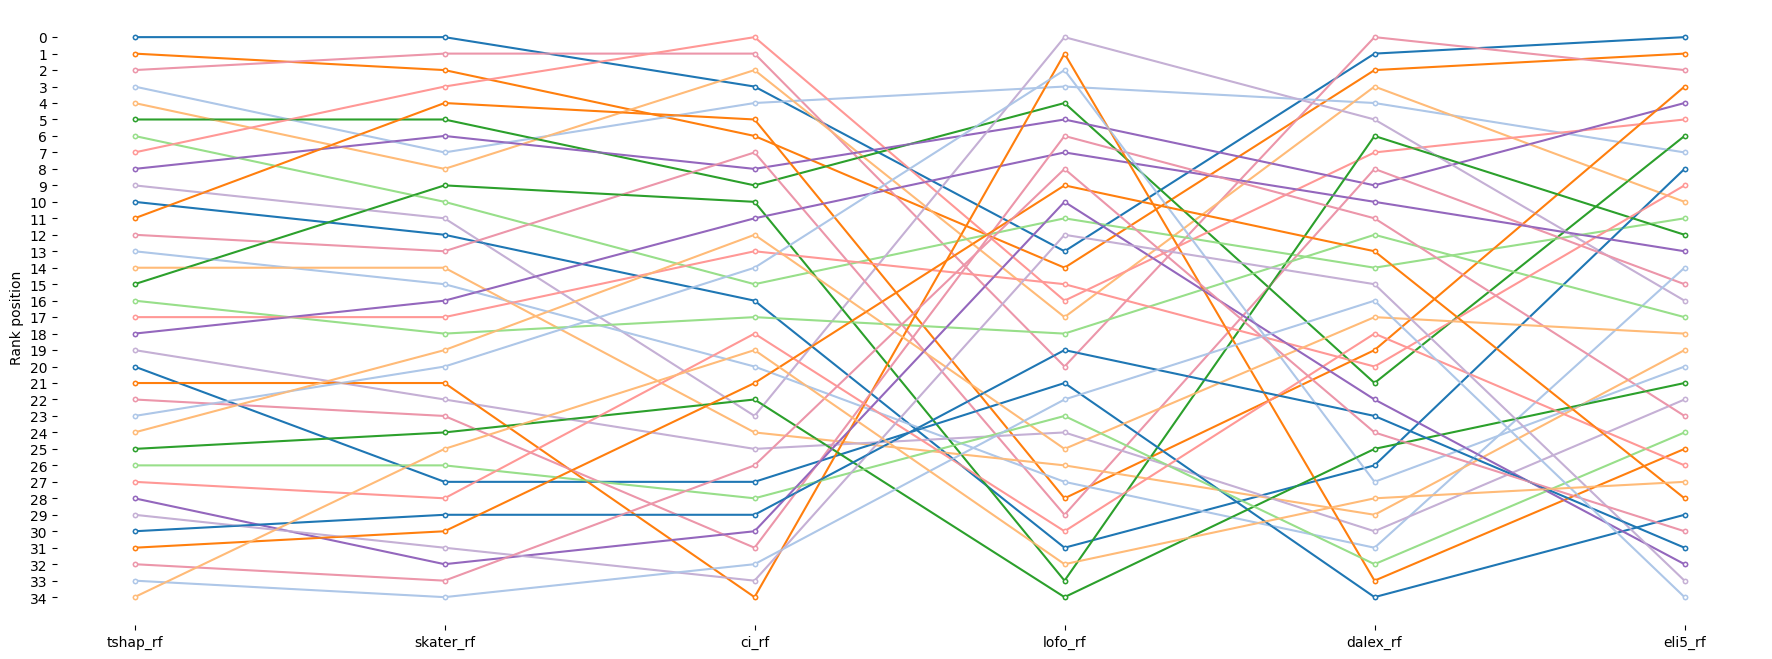

In [152]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (22,8)

colors = ['#1f77b4',
          '#ff7f0e',
          '#ec96aa',
          '#aec7e8',
          '#ffbb78',
          '#2ca02c',
          '#98df8a',
          '#ff9896',
          '#9467bd',
          '#c5b0d5',
          '#1f77b4',
          '#ff7f0e',
          '#ec96aa',
          '#aec7e8',
          '#ffbb78',
          '#2ca02c',
          '#98df8a',
          '#ff9896',
          '#9467bd',
          '#c5b0d5',
          '#1f77b4',
          '#ff7f0e',
          '#ec96aa',
          '#aec7e8',
          '#ffbb78',
          '#2ca02c',
          '#98df8a',
          '#ff9896',
          '#9467bd',
          '#c5b0d5',
          '#1f77b4',
          '#ff7f0e',
          '#ec96aa',
          '#aec7e8',
          '#ffbb78',
          '#2ca02c',
          '#98df8a',
          '#ff9896',
          '#9467bd',
          '#c5b0d5']

i = 0
for element in list_features:
  ax.plot(element["Method"],
          element["Rank"],
          ".-",                       # format of marker / format of line
          markerfacecolor="white",
          color=colors[i])
  i += 1

plt.gca().invert_yaxis()
plt.yticks(np.arange(0, q, 1))
plt.ylabel('Rank position')



i = 0
for element in list_features:
  k = len(element["Rank"]) -1

  line = 0
  if element['Name'][0] == 'duration' or element['Name'][0] == 'checking_status':
    line = 4
  else:
    line = 0.3
  ax.plot(element["Method"],
          element["Rank"],
          ".-", # format of marker / format of line
          markerfacecolor="white",
          linewidth=line, color=colors[i])

  ax.annotate("   "+element["Name"][0],
              xy=('exirt_'+m, element["Rank"][k]),
              xytext=('exirt_'+m,element["Rank"][k]),
              va="center")
  i = 1 + i

#plt.gca().invert_yaxis()
plt.yticks(np.arange(0, q, 1))


for spine in ax.spines.values():
    spine.set_visible(False)

#Human in the loop - ConeXi

In [153]:
top_n_features = 10

In [154]:
df_features_rank_copy = df_features_rank_copy.copy()
df_features_rank_step1 = df_features_rank_copy.copy()
features = df_features_rank_copy['att_original_names'] #column names of experts/measures
features_w = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] #weights for each expert/measure.
col = list(df_features_rank_copy.columns)
col.remove('att_original_names')

Step 1

In [155]:
for idl,l in enumerate(features):
  for idc,c in enumerate(col):
    for idp,p in enumerate(df_features_rank_copy.loc[:,c]):
      if l == p:
        if idp >= top_n_features:
          df_features_rank_step1.loc[idl,c] = 0
        else:
          df_features_rank_step1.loc[idl,c] = idp+1


In [156]:
df_features_rank_step1

,att_original_names,tshap_rf,eli5_rf,dalex_rf,ci_rf,skater_rf,lofo_rf,human_1,human_2,human_3,human_4,human_5,human_6
0,mes_num_crb,0,10,0,0,0,0,1,0,0,0,0,0
1,quant_lesao_corporal_crb,2,2,3,7,3,0,0,8,3,4,6,8
2,quant_ameaca_crb,1,1,2,4,1,0,7,10,0,1,7,5
3,quant_roubo_crb,3,3,1,2,2,0,4,3,8,0,4,3
4,quant_injuria_crb,6,7,0,10,6,5,0,0,0,0,0,0
5,quant_furto_crb,0,4,0,6,5,0,0,0,0,0,0,0
6,quant_lesao_no_transito_crb,0,9,0,0,0,0,0,0,0,0,0,0
7,quant_dano_no_transito_crb,8,6,8,1,4,0,0,0,0,0,0,0
8,quant_difamacao_crb,0,0,0,0,0,0,0,0,0,0,0,0
9,quant_homicidio_crb,4,8,5,5,8,4,2,1,7,10,1,10


Step 2

In [157]:
df_features_rank_step1 = df_features_rank_step1.set_index('att_original_names')

In [158]:
# initialize data of lists.
data = {}

# Creates pandas DataFrame.
df = pd.DataFrame(data, index=df_features_rank_step1.index)

for idl,l in enumerate(features):
  s_line = 0
  for idc,c in enumerate(col):
    for i in range(1,11):
      if df_features_rank_step1.loc[l,c] <= i and df_features_rank_step1.loc[l,c] !=0 :
        s_line = (s_line + 1) * features_w[idc]
    df.loc[l,'S'] = s_line


Result

In [159]:
df.sort_values('S',ascending=False)

,S
att_original_names,
quant_roubo_crb,77.0
quant_ameaca_crb,71.0
quant_homicidio_crb,67.0
quant_lesao_corporal_crb,64.0
quant_trafico_de_drogas_crb,41.0
quant_tentativa_de_homicidio_crb,35.0
quant_estupro_crb,28.0
quant_dano_no_transito_crb,28.0
quant_conflitos_familiares_crb,23.0
